# Setting up a capacitated routing problem

This jupytur notebook goes through the creation of a capacitated vehicle routing problem for the [**ors-example**](Link to be added). First, we import some necessary packages.

In [1]:
from IPython.display import display, HTML
import openrouteservice
import folium
from shapely import wkt, geometry
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

For the capacitated vehicle routing problem we will use the [**dataset from "Augerat, et al. Set A"**](https://www.coin-or.org/SYMPHONY/branchandcut/VRP/data/index.htm.old#A). The dataset contains 32 nodes (including 1 depot) with their demands and 5 vehicles with a capacity of 100 each. We first import the dataset and extract the relevant information from the dataset. The following table shows the extracted data. The x-coordinates and y-coordinates represent the position of the nodes. The column "demand" shows the "demanded order" that needs to be delivered to the respective node. The node with zero demand is the depot (first node).  

In [2]:
def str_to_num(lst_2d, num_type='int'):
    for i, item in enumerate(lst_2d):
        for j, num in enumerate(item):
            if num_type == 'int':
                lst_2d[i][j] = int(num)
            elif num_type == 'float':
                lst_2d[i][j] = float(num)
    return lst_2d

def read_file(file_path): # "A-n32-k5.vrp"
    decider = 0 
    nodes = []
    demands = []
    with open(file_path, 'r') as file:
        for line in file:
            if line == 'NODE_COORD_SECTION \n':
                decider = 1
            elif line == 'DEMAND_SECTION \n':
                decider = 2
            elif line == 'DEPOT_SECTION \n':
                decider = 0
        
            if decider == 0:
                continue
            elif decider == 1:
                nodes.append(line.lstrip().rstrip().split(' '))
            elif decider == 2:
                demands.append(line.lstrip().rstrip().split(' '))
    file.close()
    nodes = np.delete(np.array(str_to_num(nodes[1:])), 0, 1)
    demands = np.delete(np.array(str_to_num(demands[1:])), 0, 1)
    data = np.concatenate((nodes, demands), axis=1)
    return data

data = read_file("A-n32-k5.vrp")
df_data = pd.DataFrame(data, columns=['x-coordinate', 'y-coordinate', 'demand'])
df_data.columns.name = 'node number'
display(df_data)

node number,x-coordinate,y-coordinate,demand
0,82,76,0
1,96,44,19
2,50,5,21
3,49,8,6
4,13,7,19
5,29,89,7
6,58,30,12
7,84,39,16
8,14,24,6
9,2,39,16


To give the rather abtract problem a real world application, we map the nodes to locations in the german city Heidelberg. First, we need to calculate the borders of Heidelberg. For this endeavor, we use the open street map and a [**python script**](http://polygons.openstreetmap.fr/index.py) to compute the polygon representing the borders of Heidelberg. The generated file needs to be read into our jupyter notebook and prepared in such a way that it is useful for further processing steps. Furthermore, we compute the centroid of the polygon and plot it with the folium package to visualize the polygon and double-check, if everything went well. 

In [3]:
def read_file_polygon(file_path): # 'HD_polygon.txt'
    with open(file_path, 'r') as file:
        polygon = []
        for line in file:
            polygon.append(line.lstrip().rstrip().split('\t'))
        polygon = np.array(str_to_num(polygon, 'float'))
    file.close()
    return polygon

def get_geometry_polygon(polygon):
    polygon_str = ""
    for item in polygon:
        polygon_str += str(item)[2:-1] + ", " 
    polygon_str = 'Polygon ((' + polygon_str[:-2] + '))'    
    poly_geom = wkt.loads(polygon_str) # load geometry from Polygon string
    poly_coords = list(poly_geom.exterior.coords) # get coords from exterior ring
    poly_coords = [(y,x) for x,y in poly_coords] # swap (x,y) to (y,x). Really leaflet?!
    poly_centroid = poly_geom.centroid 
    return poly_coords, poly_centroid

def plot_polygon(poly_coords, poly_centroid):
    polygon_map = folium.Map(tiles='stamenterrain',location=(poly_centroid.y, poly_centroid.x), zoom_start=12)
    folium.Marker([poly_centroid.y, poly_centroid.x], popup='<strong>Polygon Centroid</strong>').add_to(polygon_map)
    folium.features.PolygonMarker(poly_coords, popup='Heidelberg Polygon', color='#000000', fill_color='#140e8c', fill_opacity=0.2, weight=3).add_to(polygon_map)
    display(polygon_map)

polygon = read_file_polygon('HD_polygon.txt')
poly_coords, poly_centroid = get_geometry_polygon(polygon)
plot_polygon(poly_coords, poly_centroid)

Now, we need to transform the nodes coordinates in such way that they are within the polygon borders of Heidelberg, while maintaining their spacial structure. Keep in mind that the border of the Heidelberg polygon are giving in latitude and longitude, whereas the [**dataset from "Augerat, et al. Set A"**](https://www.coin-or.org/SYMPHONY/branchandcut/VRP/data/index.htm.old#A) assumes cartesian coordinates. To ensure comparability between the node positions and the Heidelberg polygon, we could use the Mercator projection:

$$latitude = arcsin(tanh(y))$$

$$longitude = x + \lambda_0$$

where $\lambda_0$ is the longitude of the map center. However, to simply things we will just says (compare Notes):

$$latitude = y$$

$$longitude = x$$

To get a rough idea of the result, we can first plot the nodes positions as well as the polygon and compare them to each other. 

### Notes:
The capacitated vehicle routing problem is rotation and linear translation invariant. Furthermore, we do not care too much about exactly representing the initial capacitated vehicle routing problem, but rather generating our own CVR problem using the provided dataset. This approach will prevent us from creating a CVR problem that is constructed in a bias way to fit our solution. NO CHEATING ALLOWED!!  

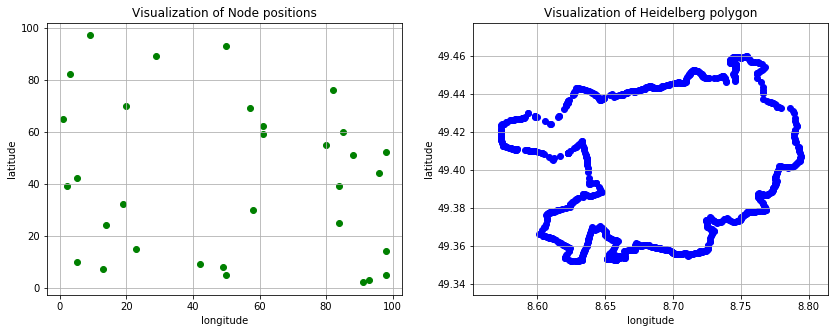

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].scatter(data[:,0], data[:,1], c= 'g')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].set_title('Visualization of Node positions')
ax[0].grid(True)
ax[1].scatter(polygon[:, 0], polygon[:, 1], c='b') 
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')
ax[1].set_title('Visualization of Heidelberg polygon')
ax[1].grid(True)
plt.show()

A closer look at the axes of both diagrams reveal that the node positions have a different order of magnitude compared to the polygon. To correct the discrepancy between node positions and polygon, we first compute the centroid of the node positions and then do a linear translation of all nodes such that the centroid of the node positions has the same coordinates as the centroid of the polygon. In the final step, we will move all nodes towards their centroid until all nodes are within the polygon. 

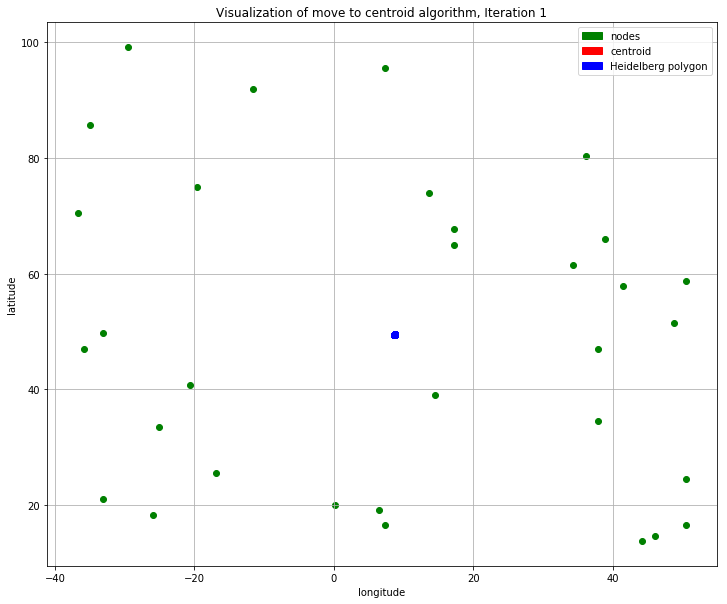

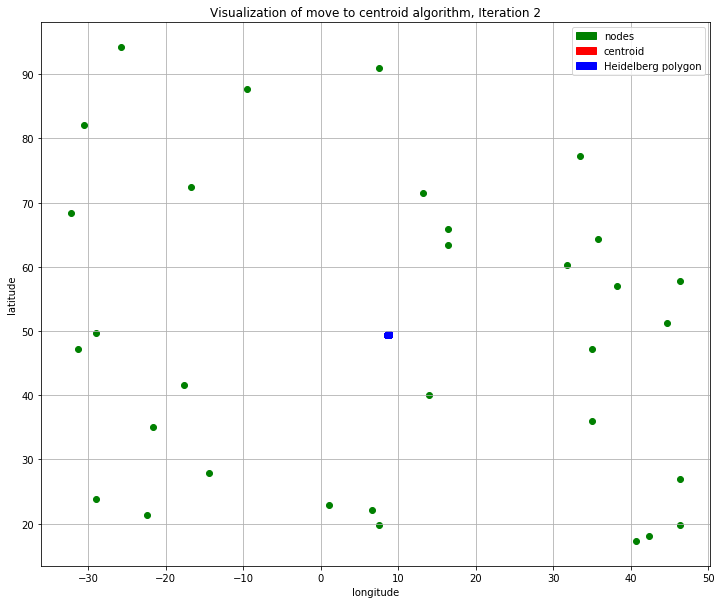

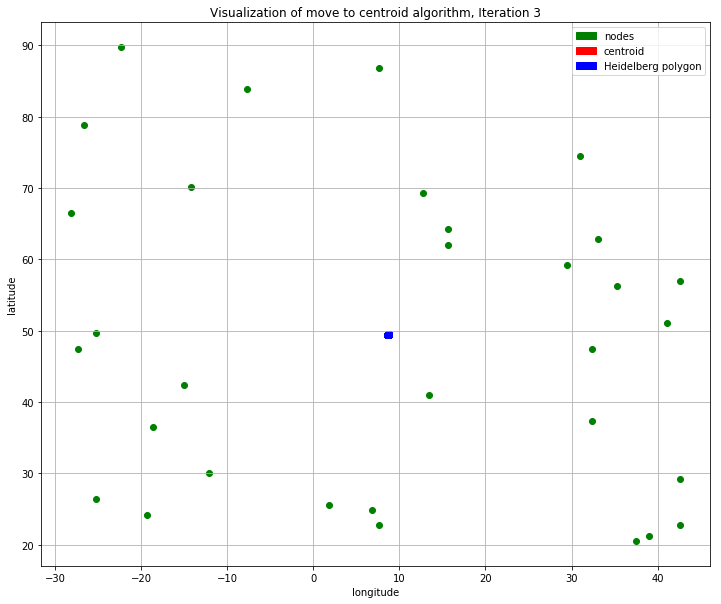

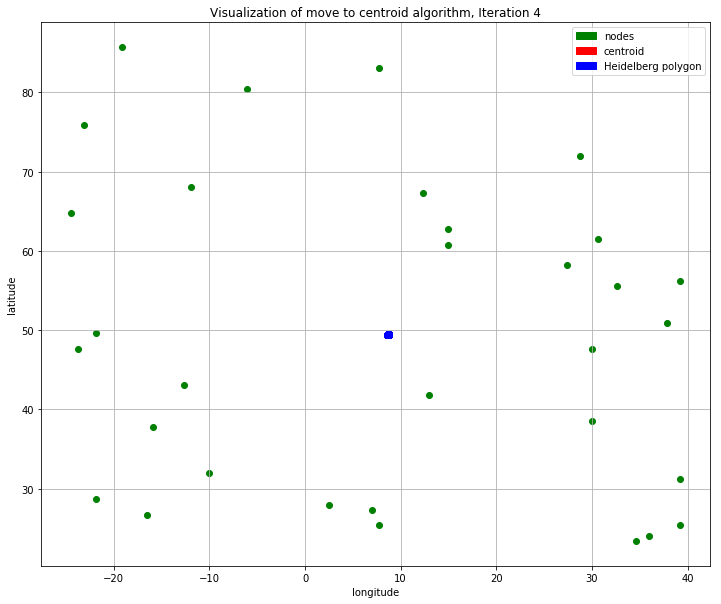

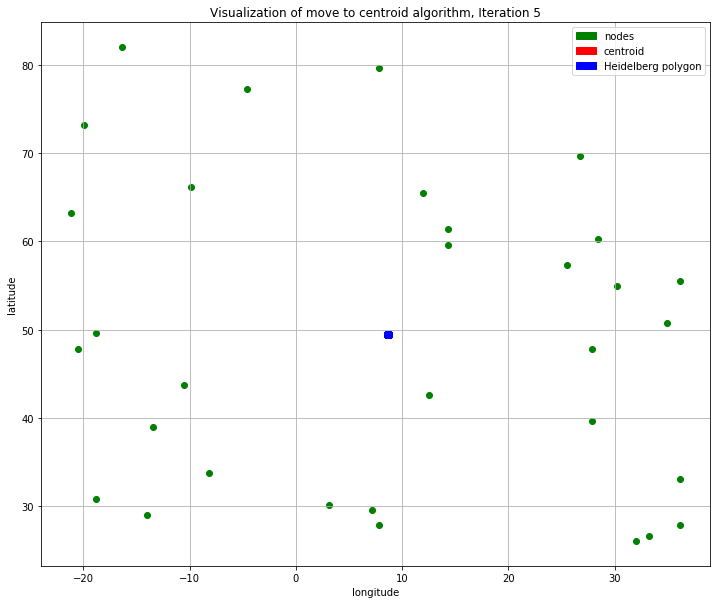

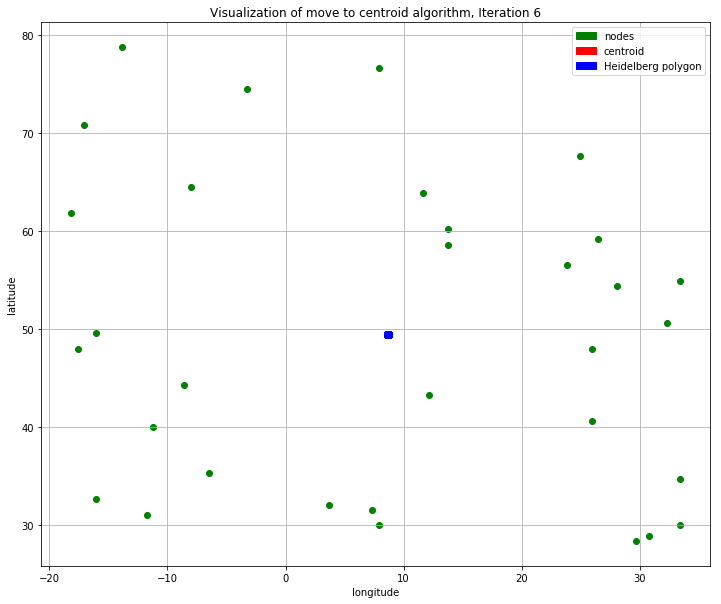

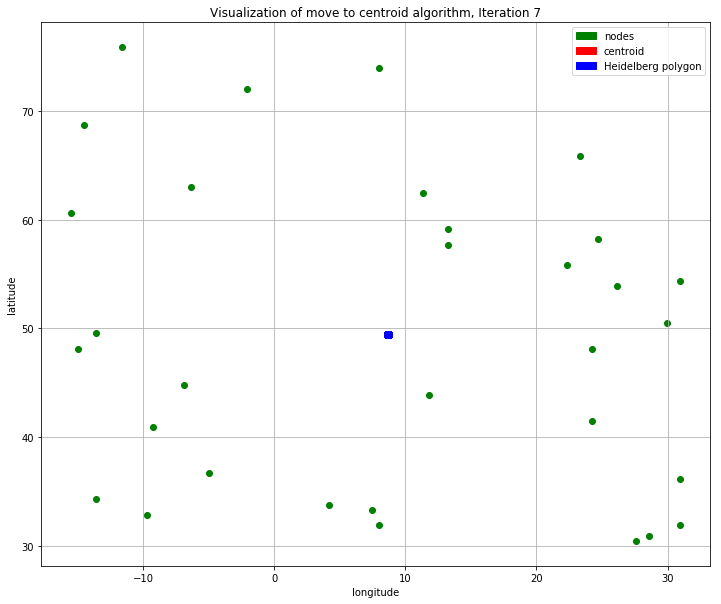

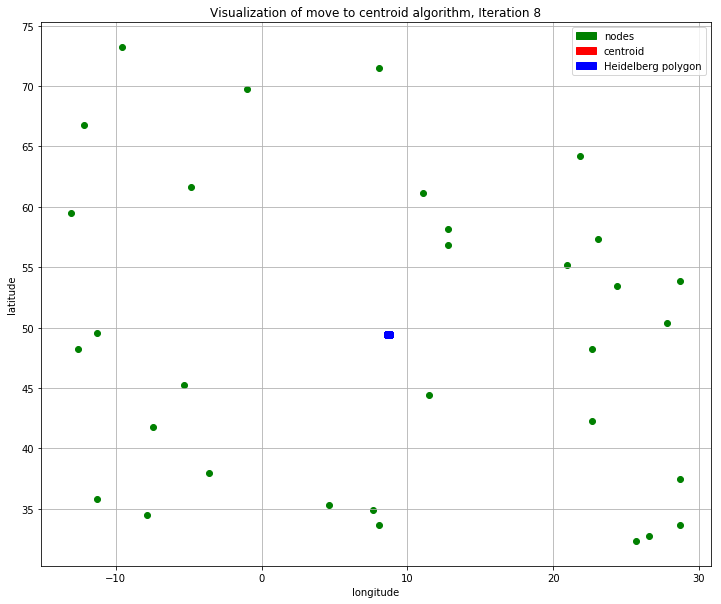

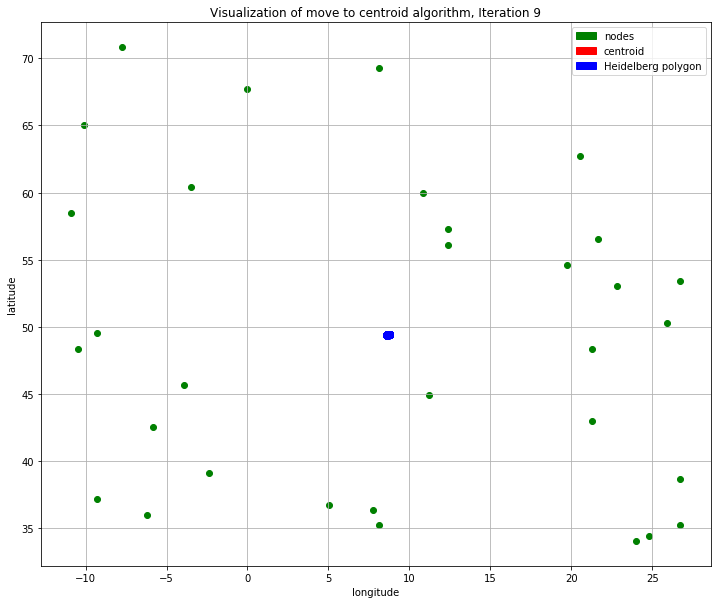

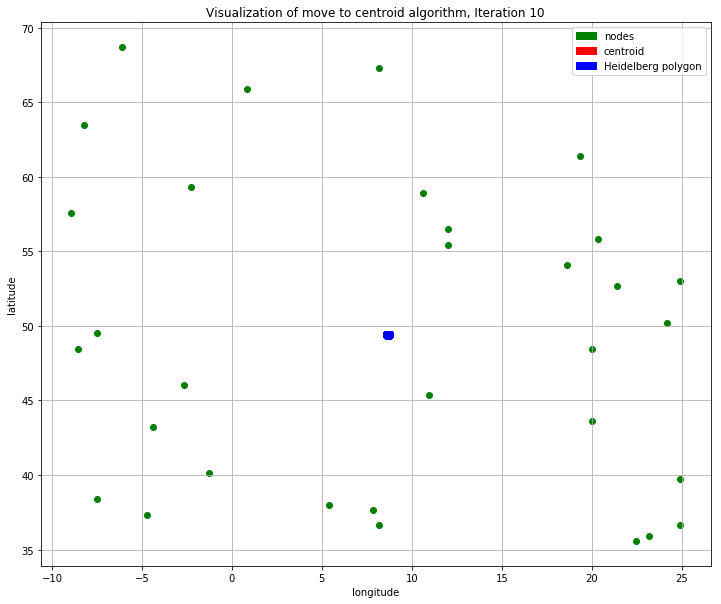

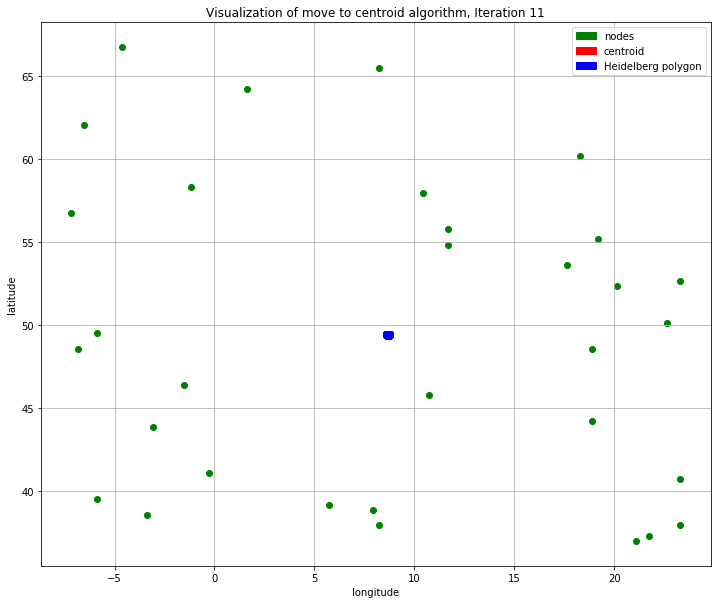

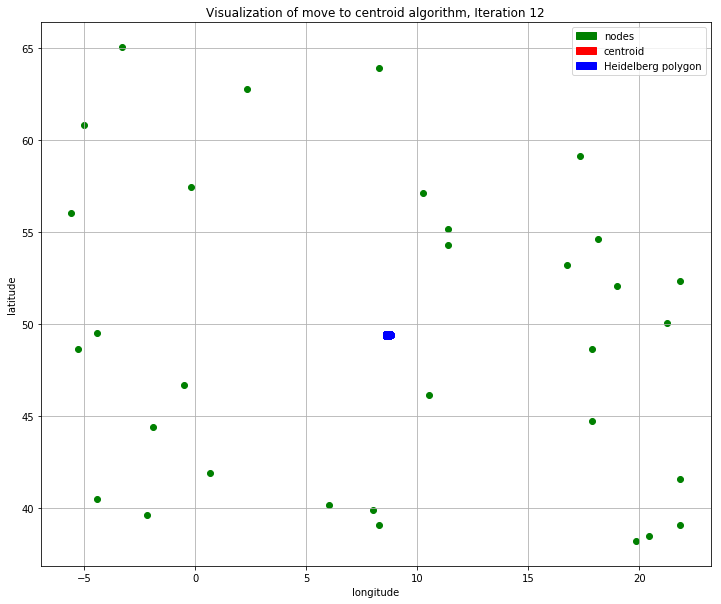

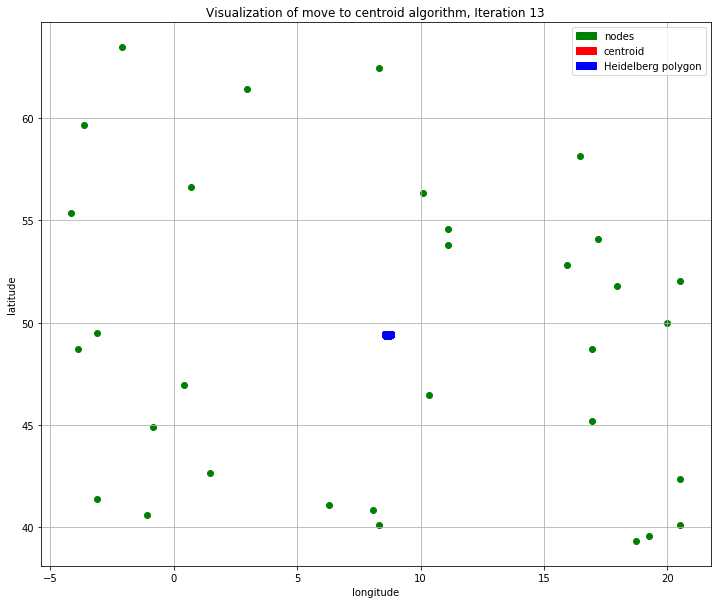

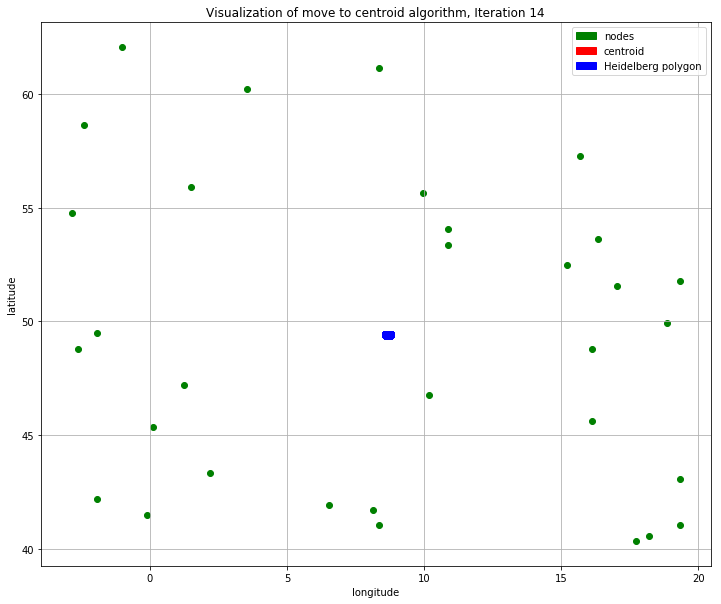

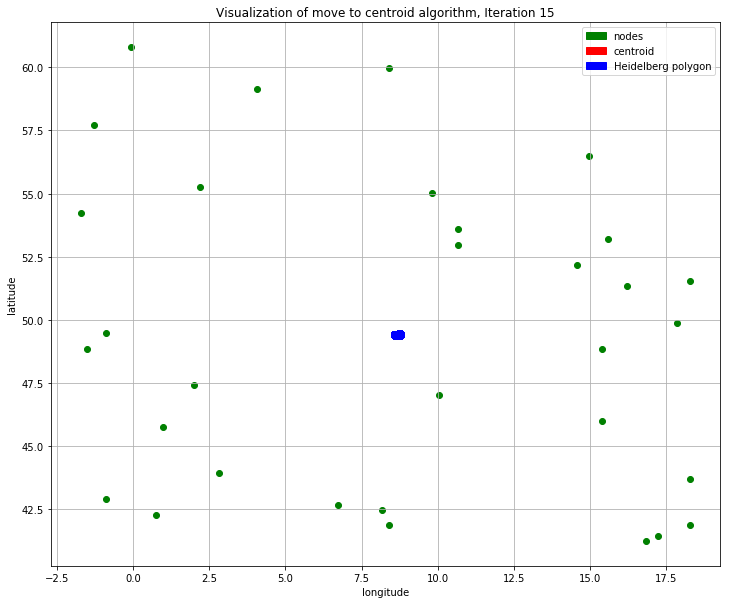

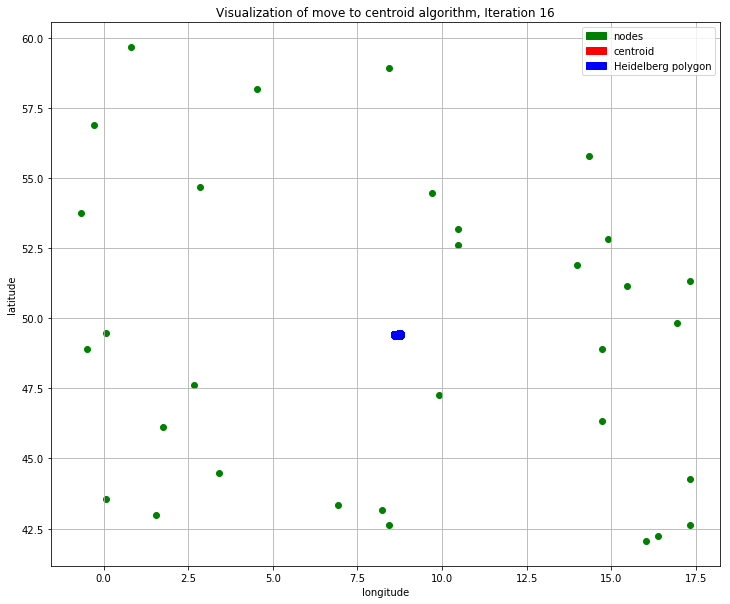

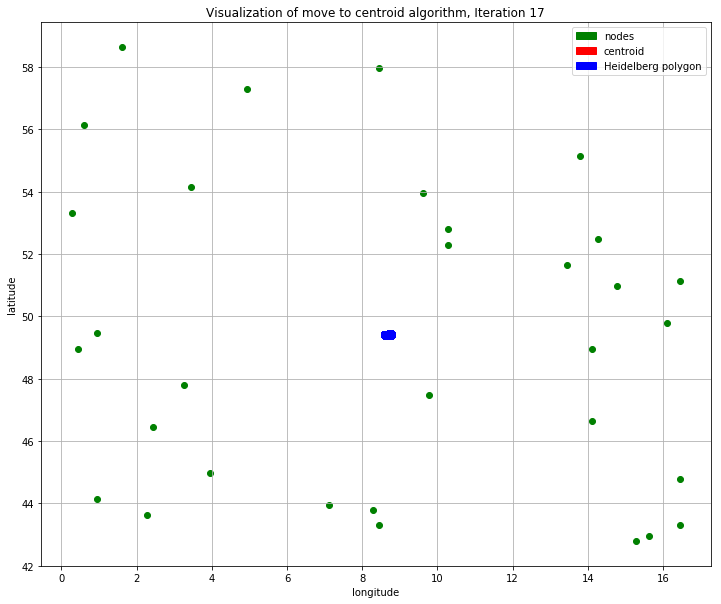

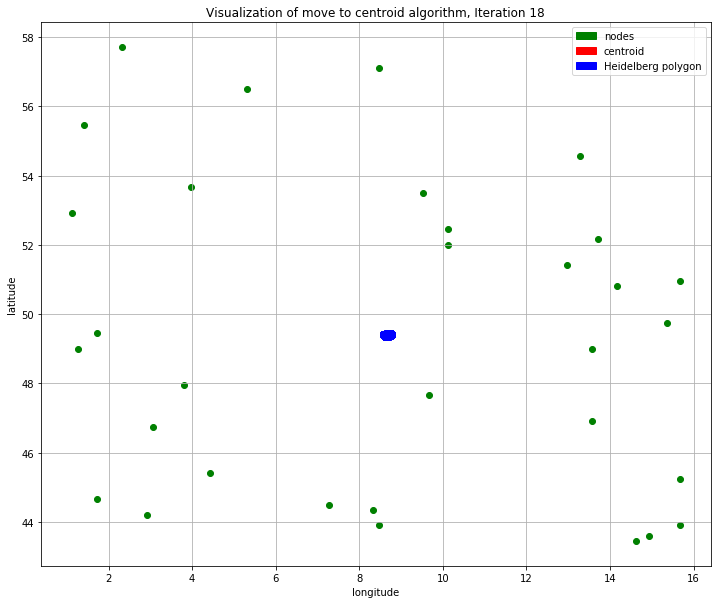

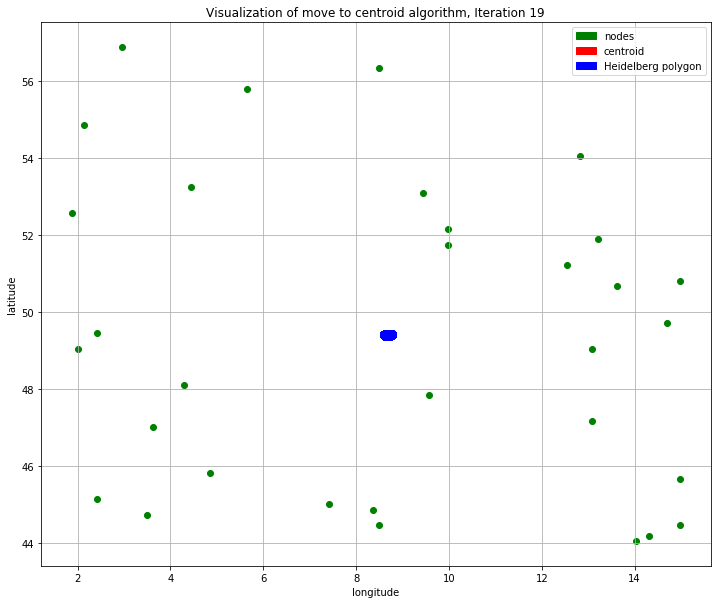

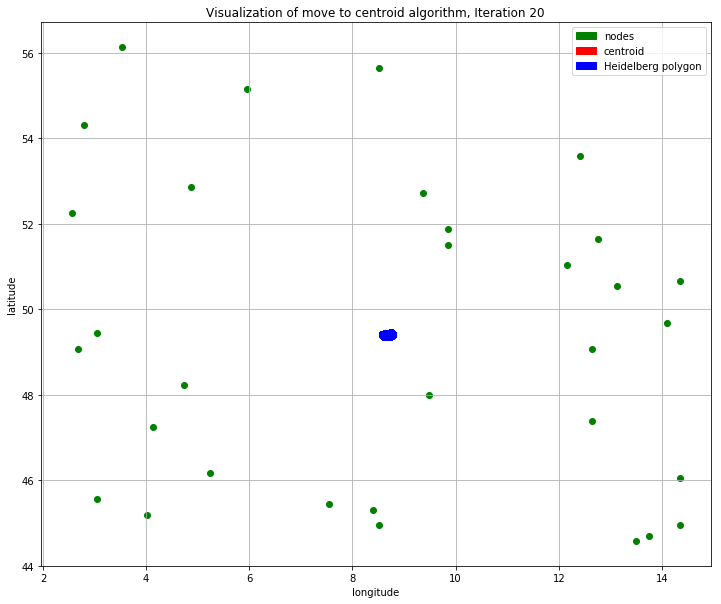

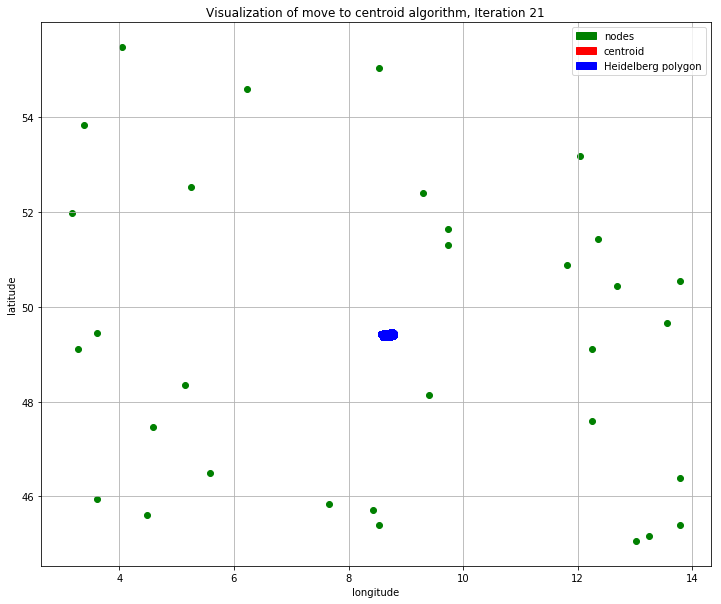

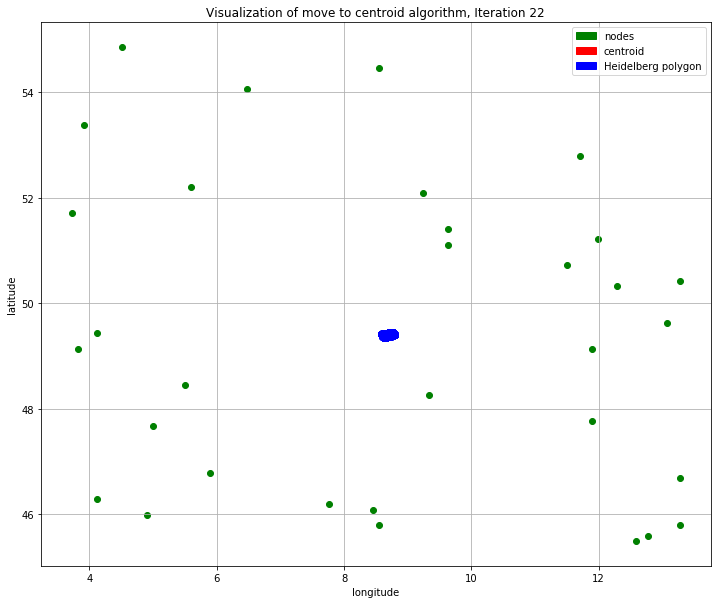

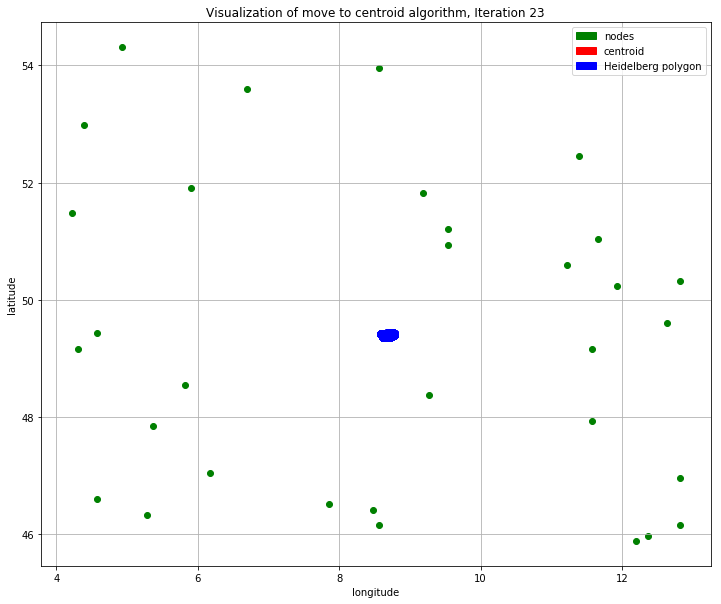

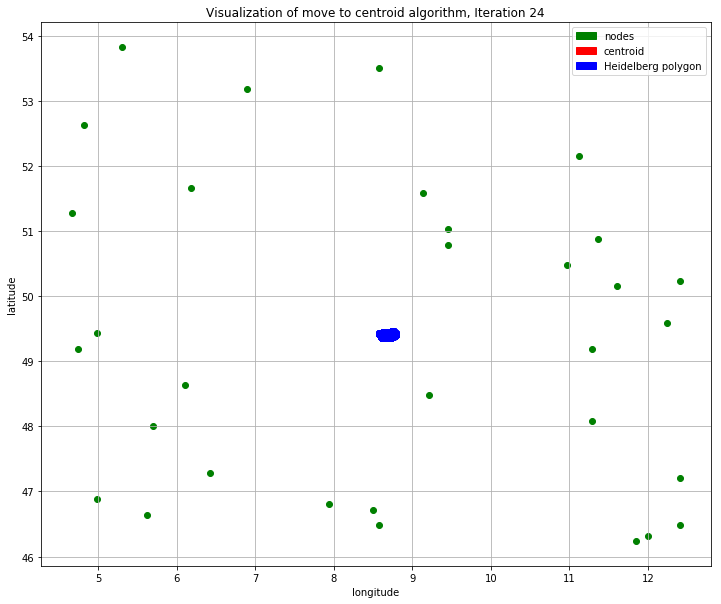

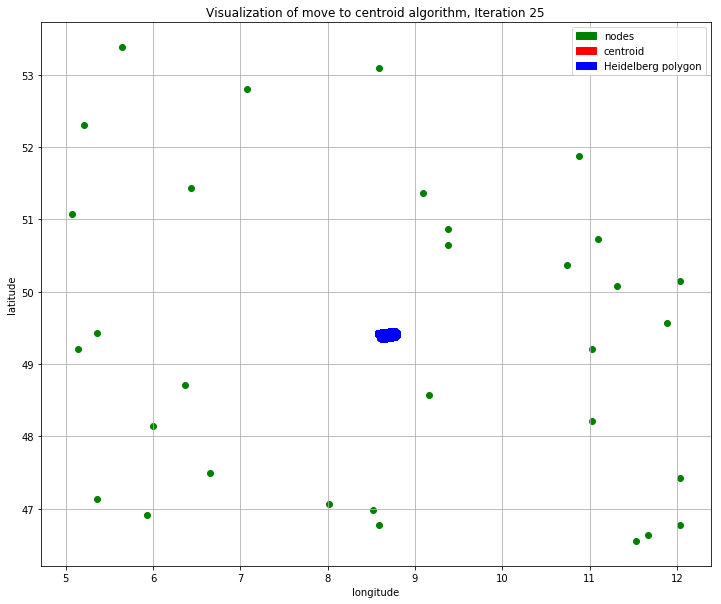

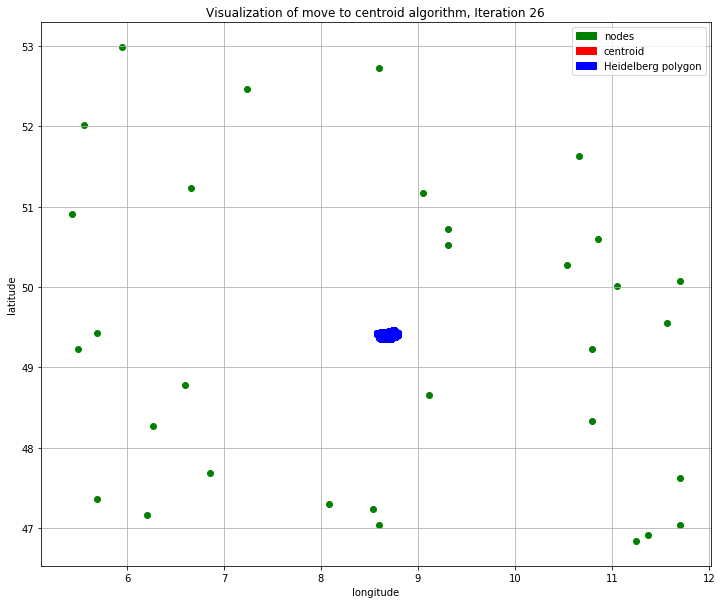

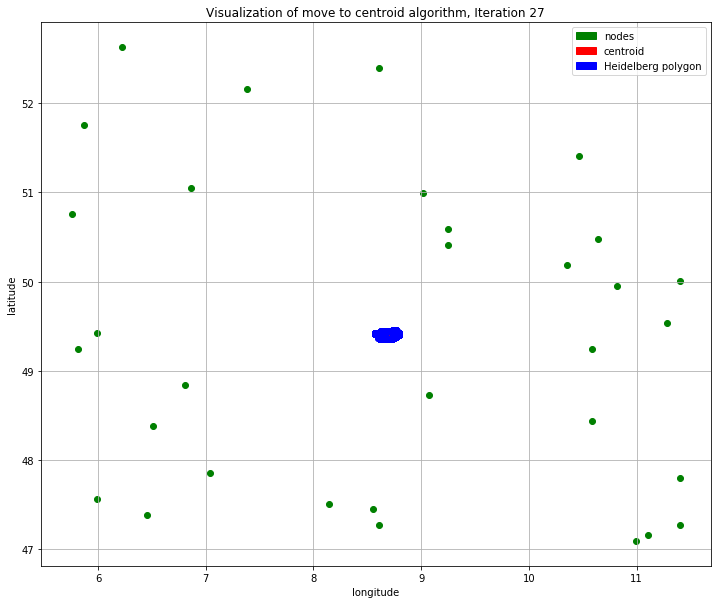

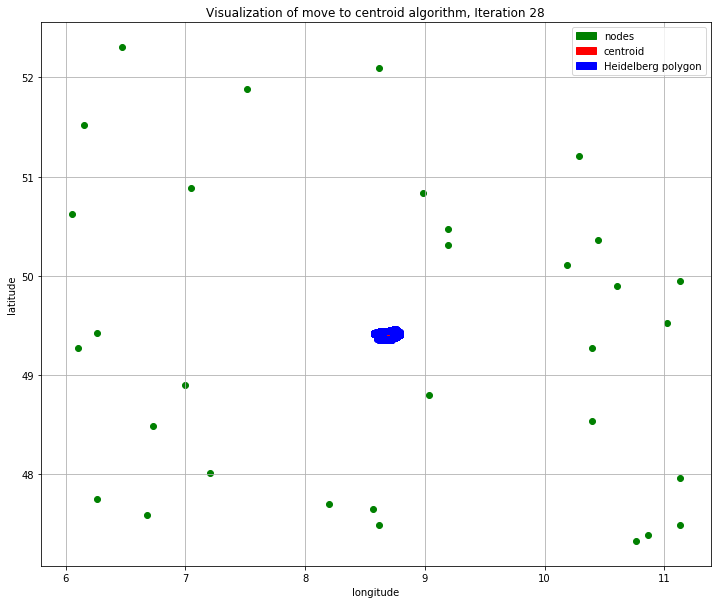

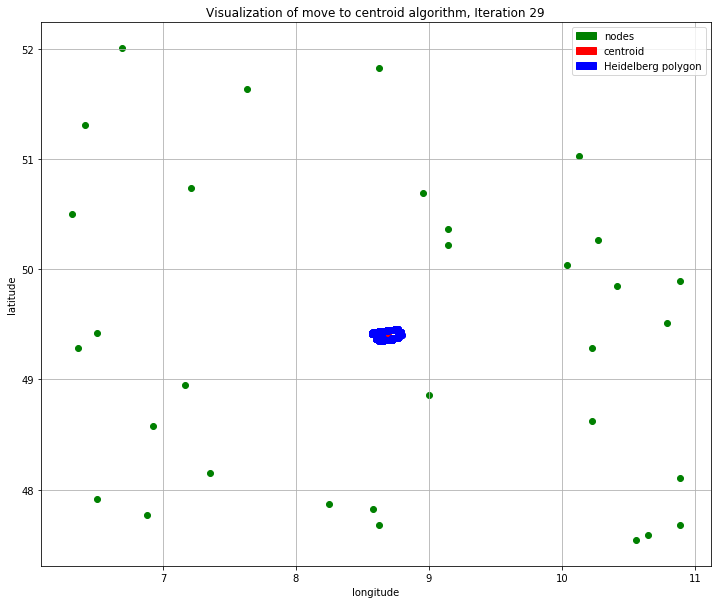

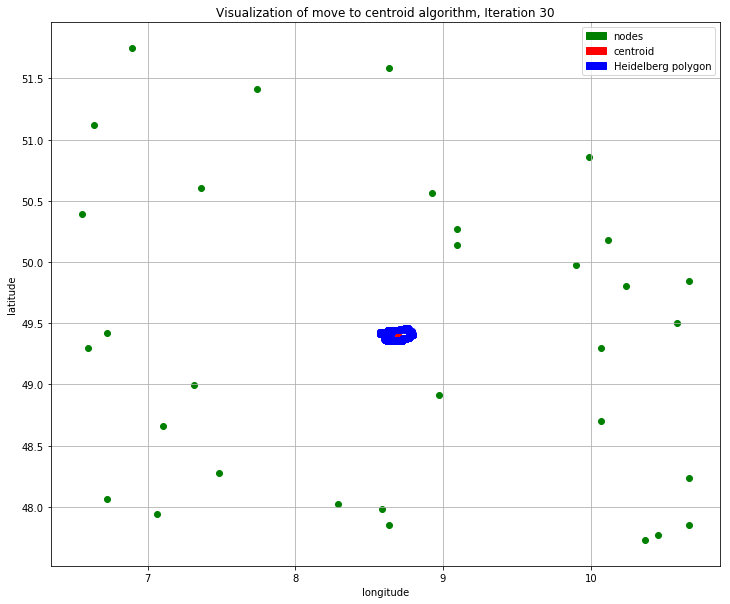

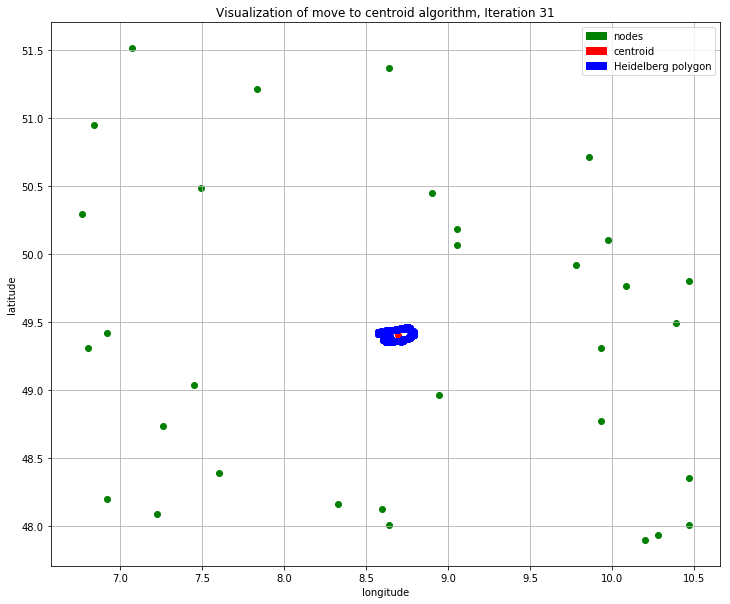

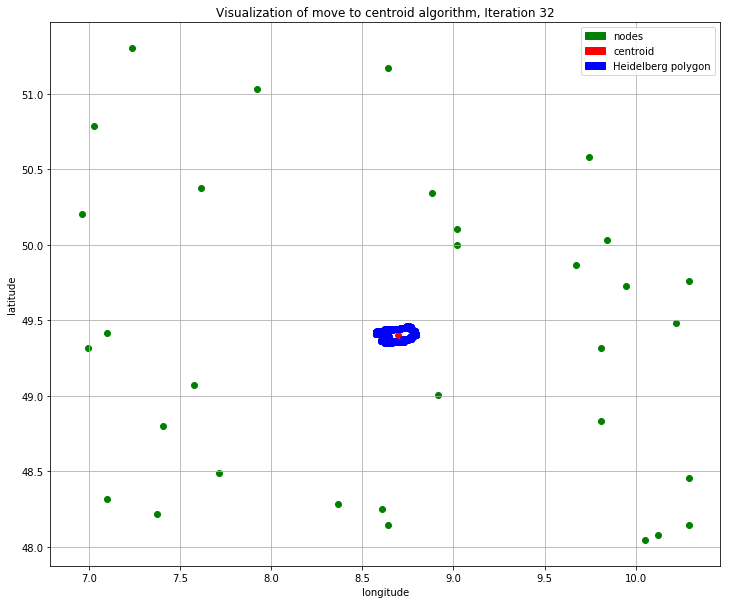

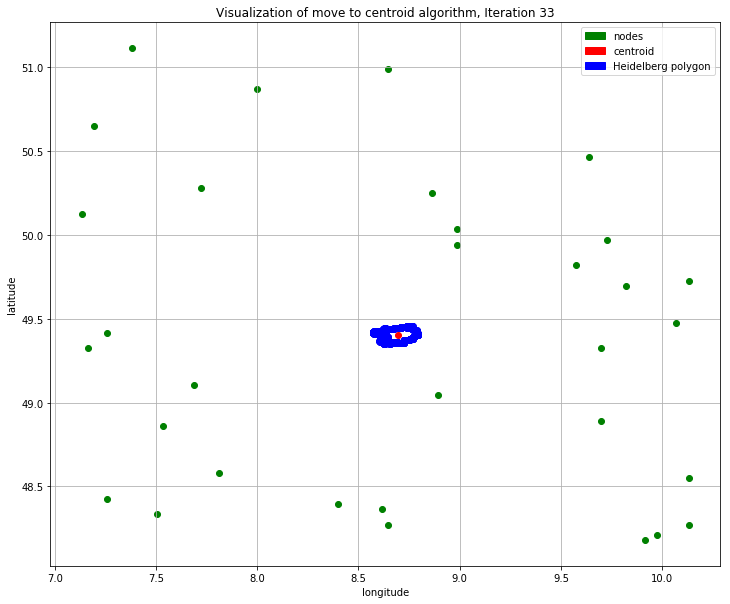

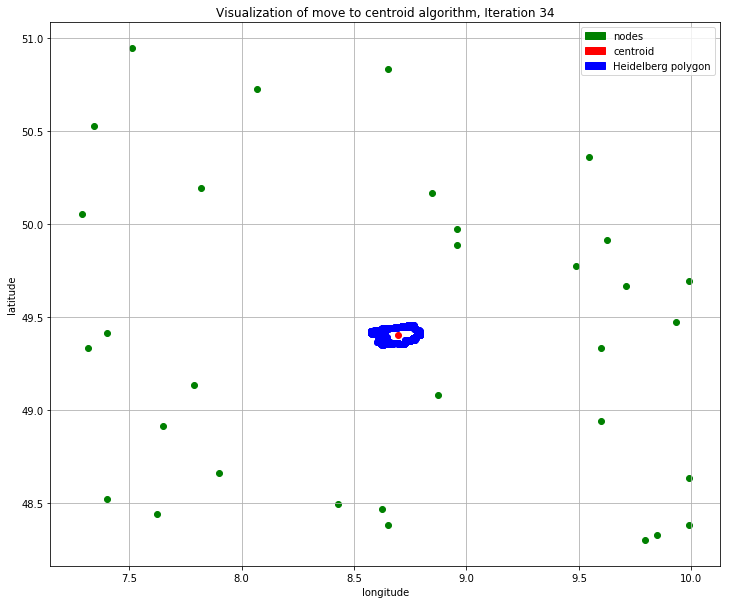

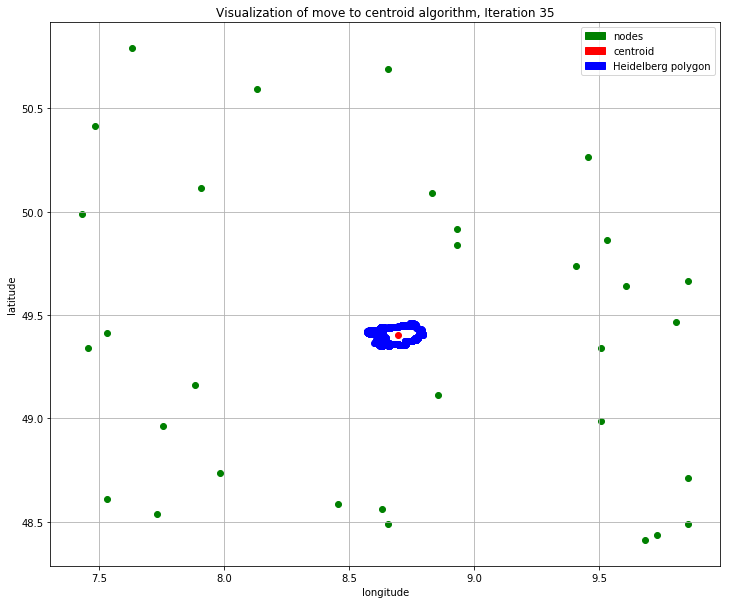

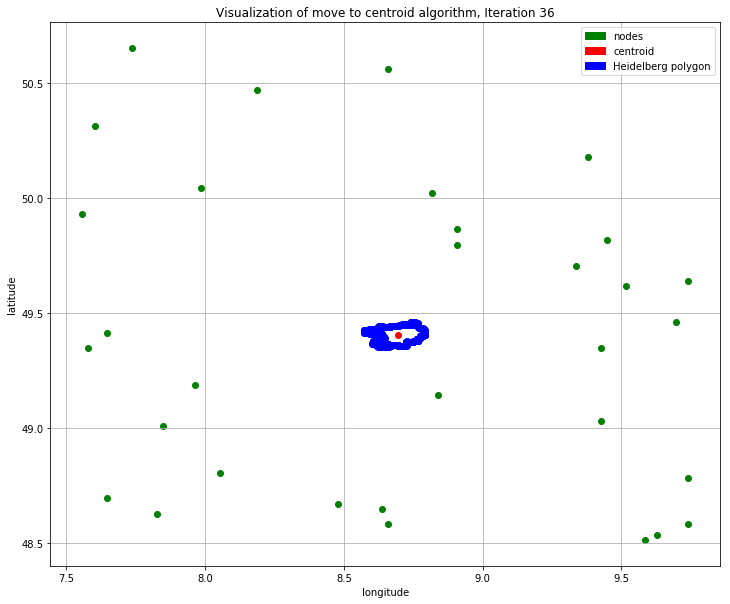

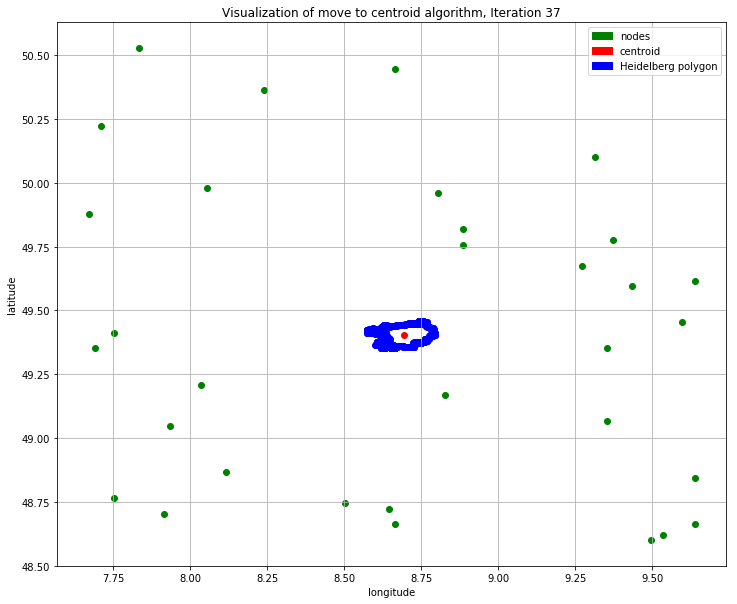

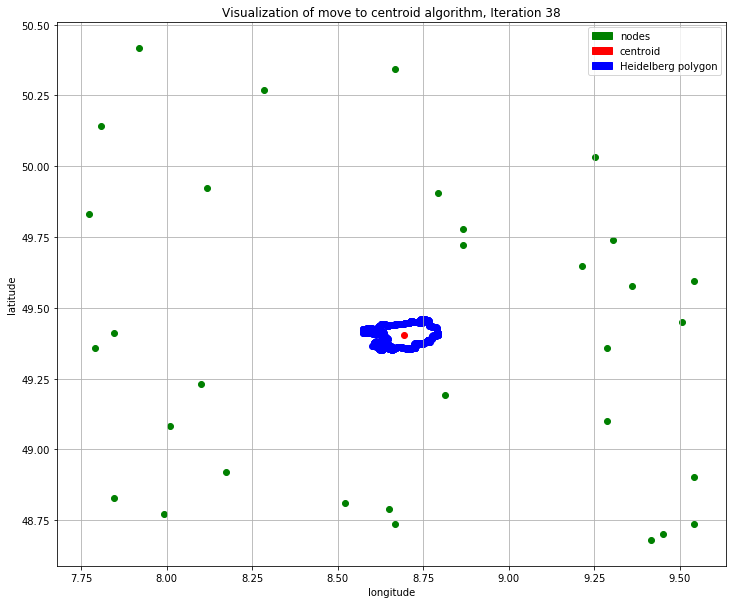

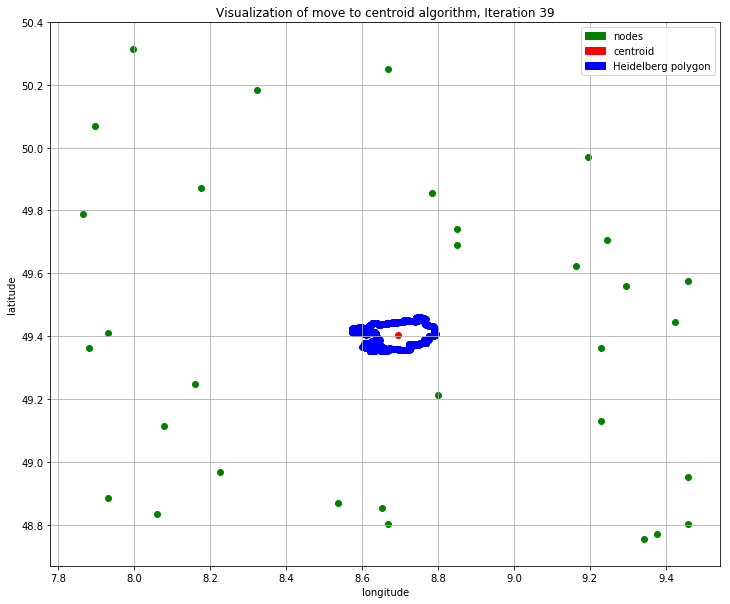

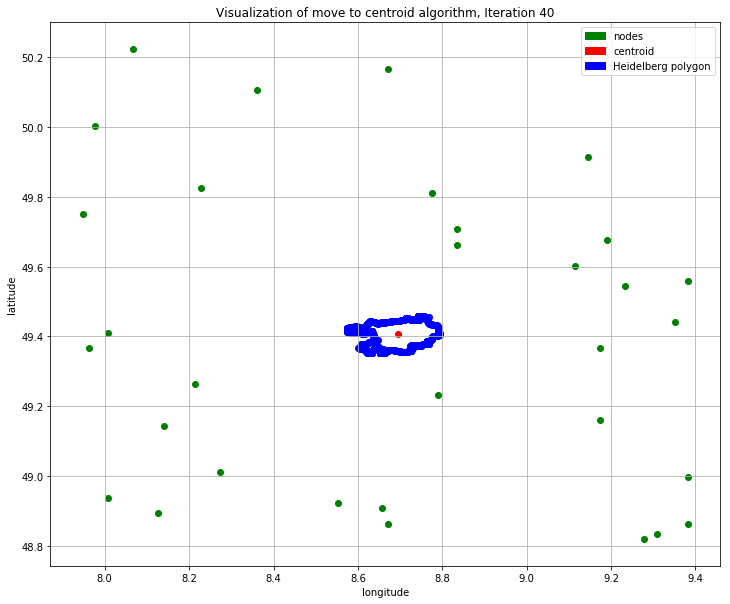

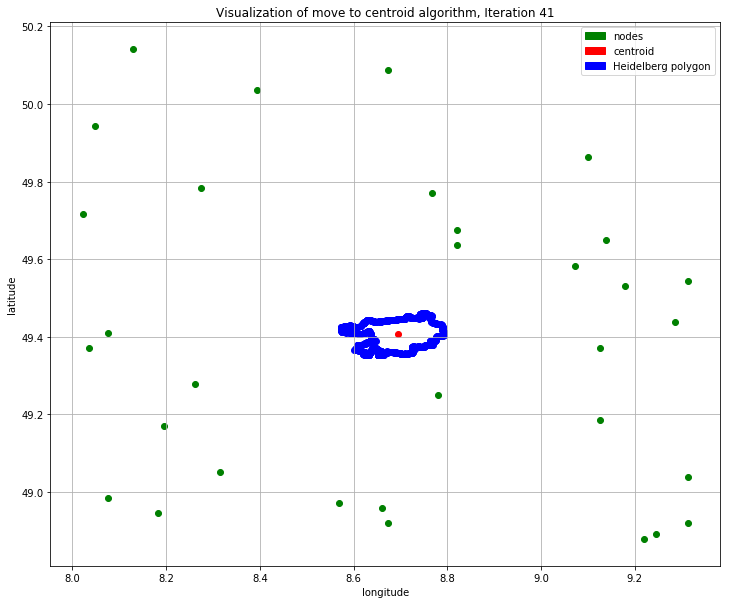

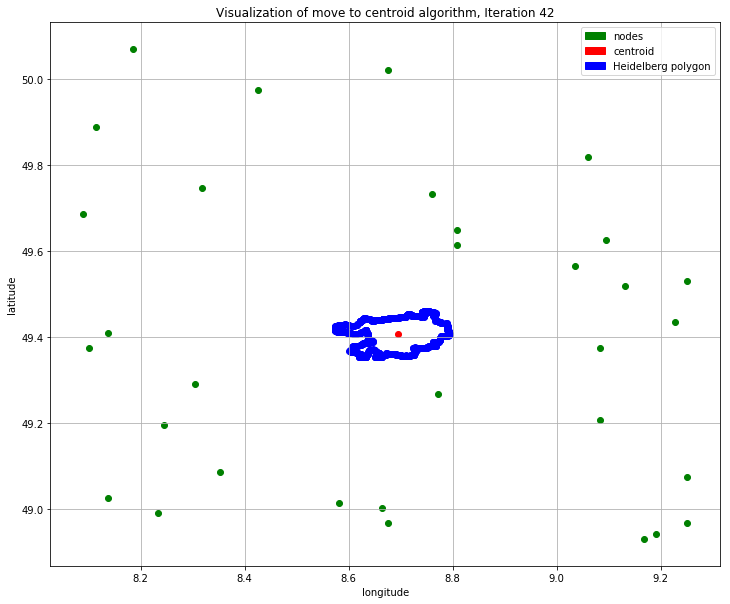

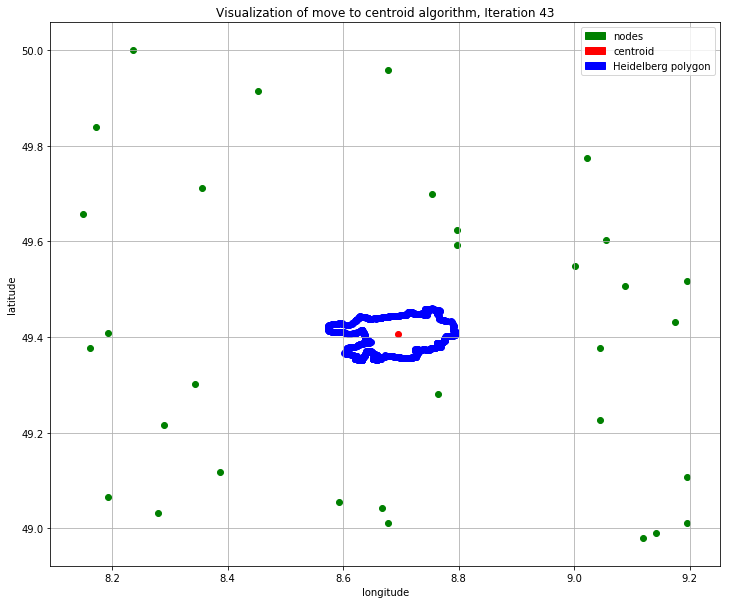

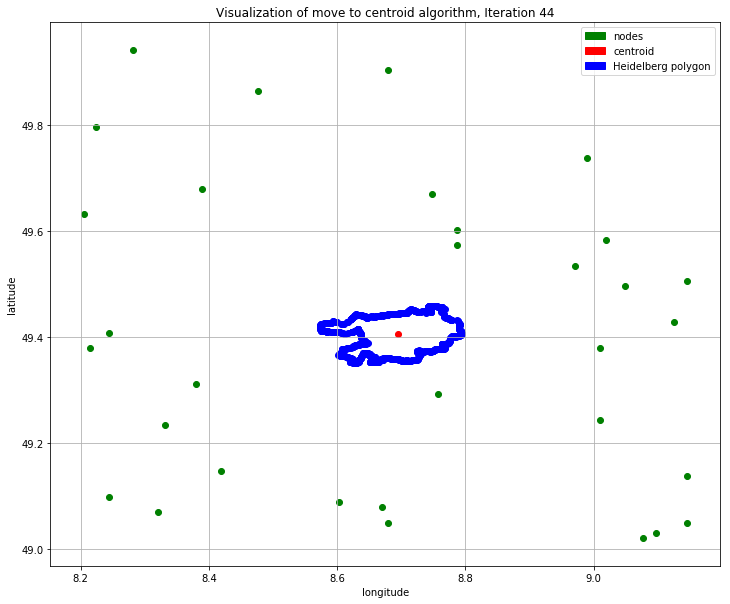

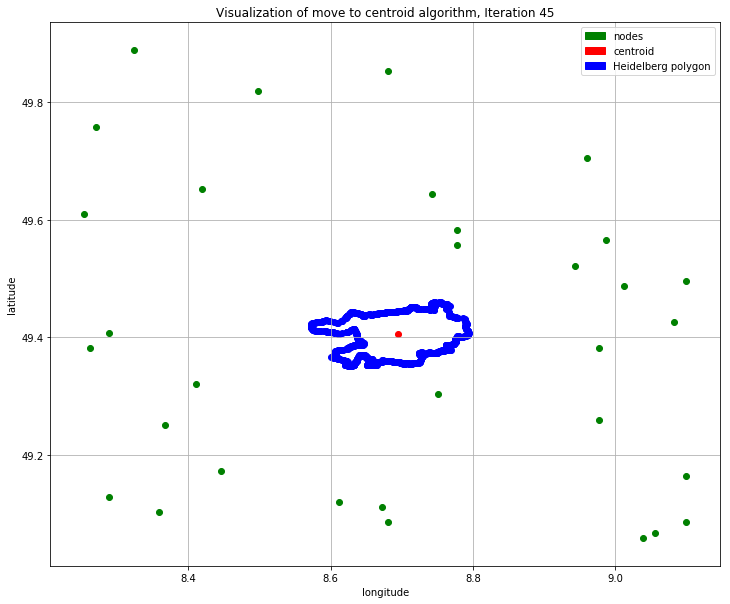

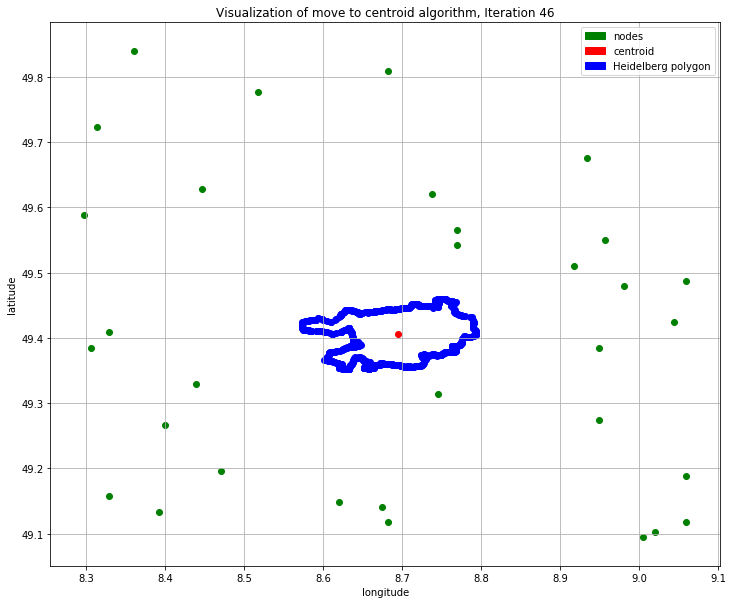

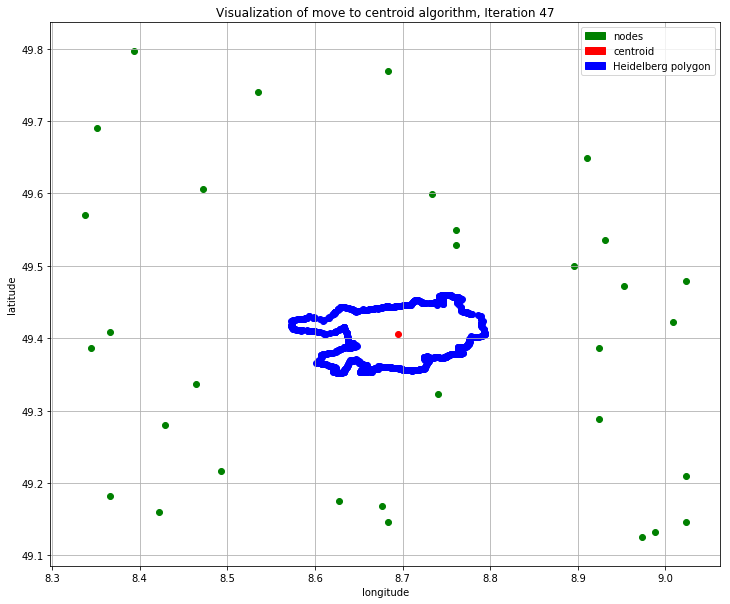

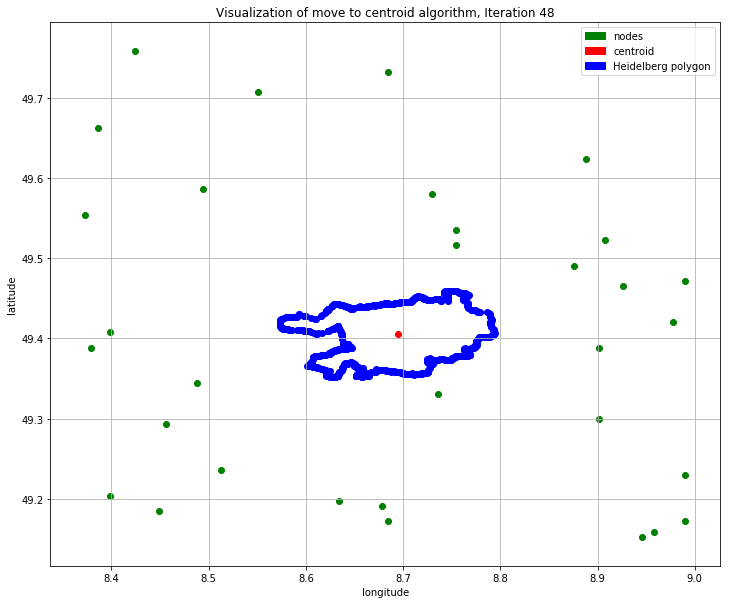

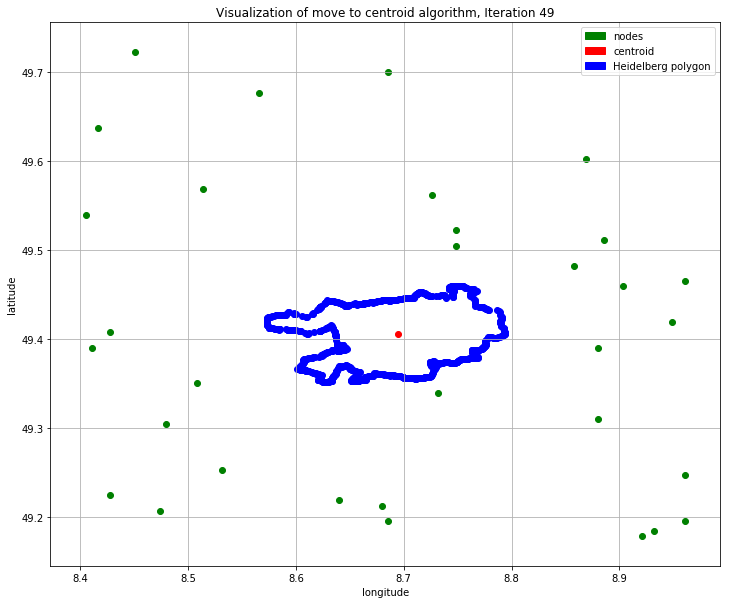

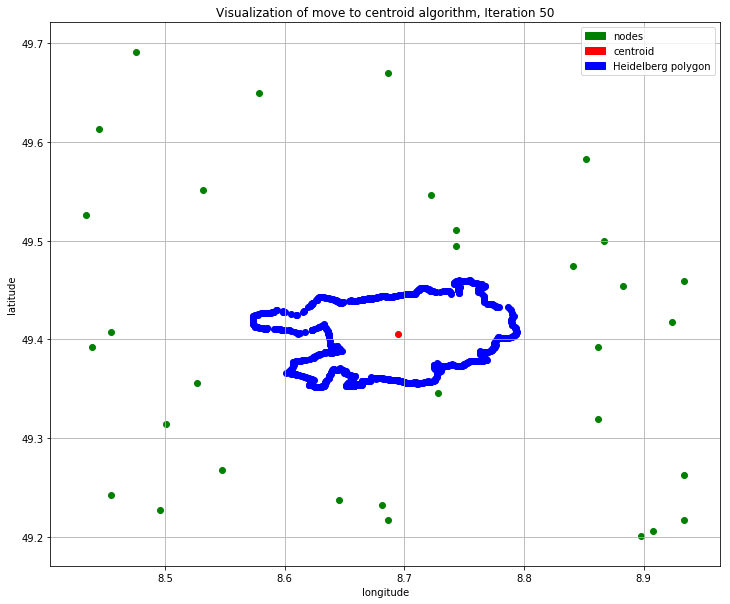

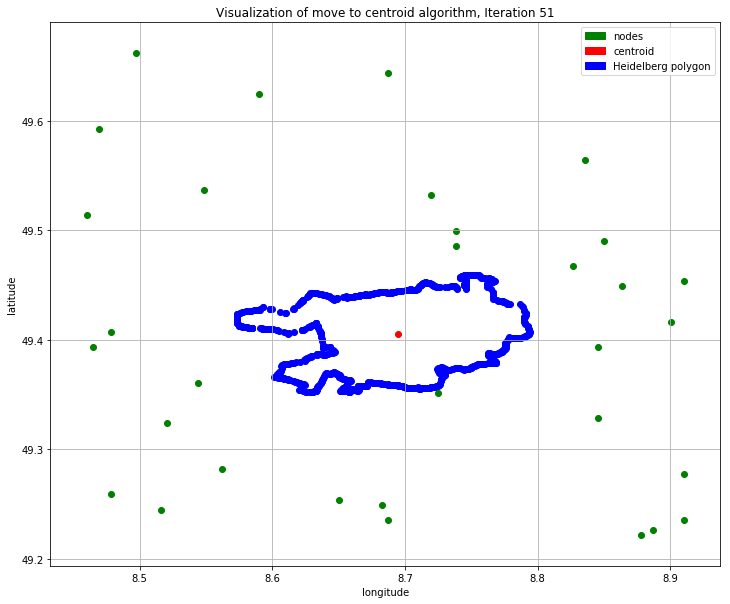

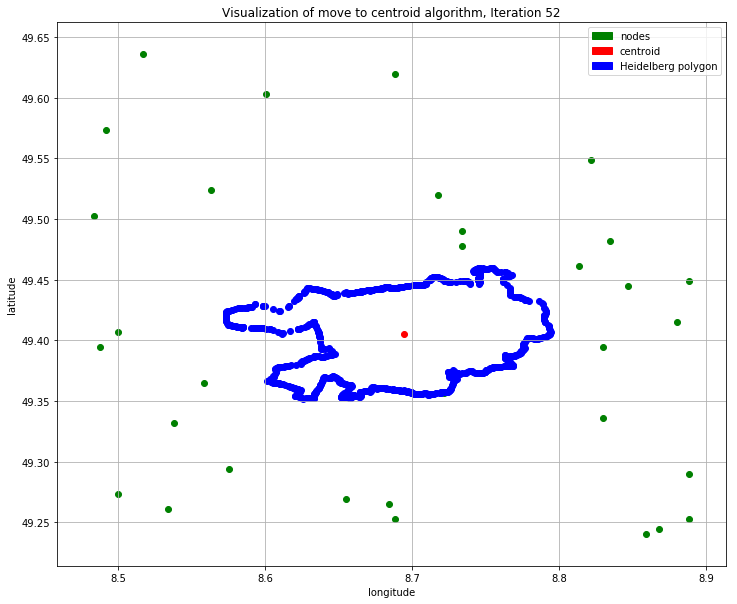

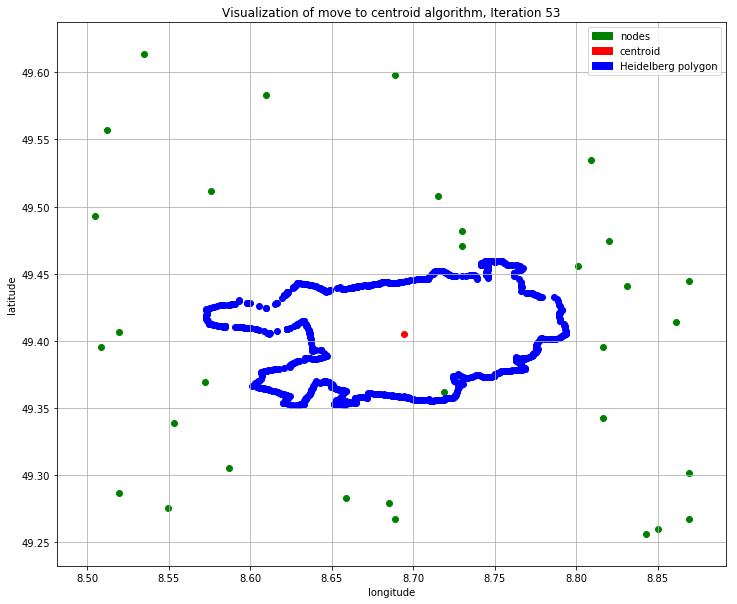

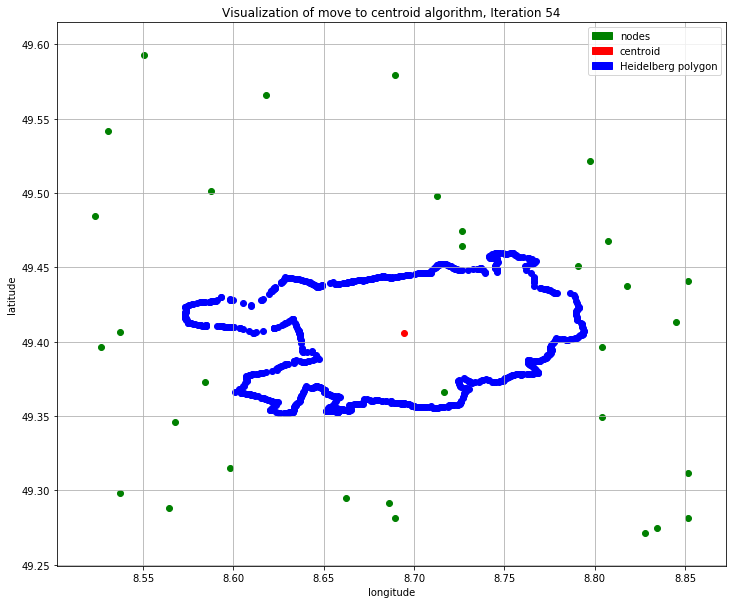

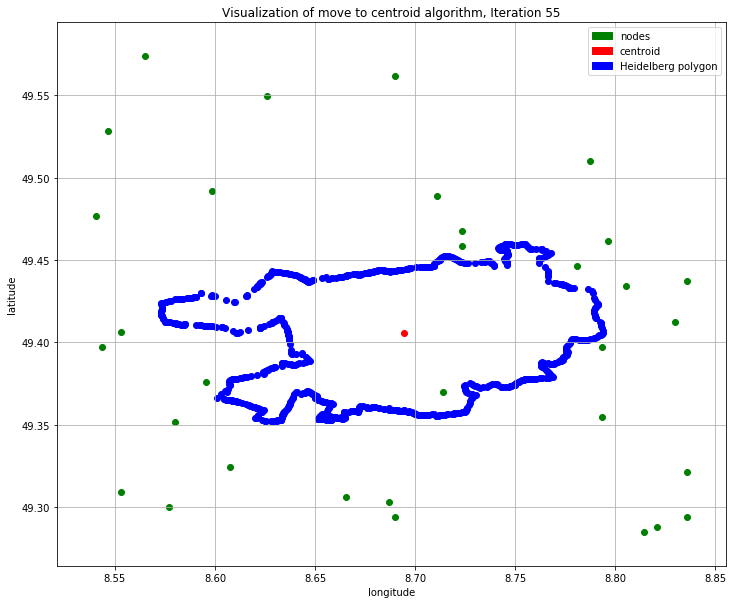

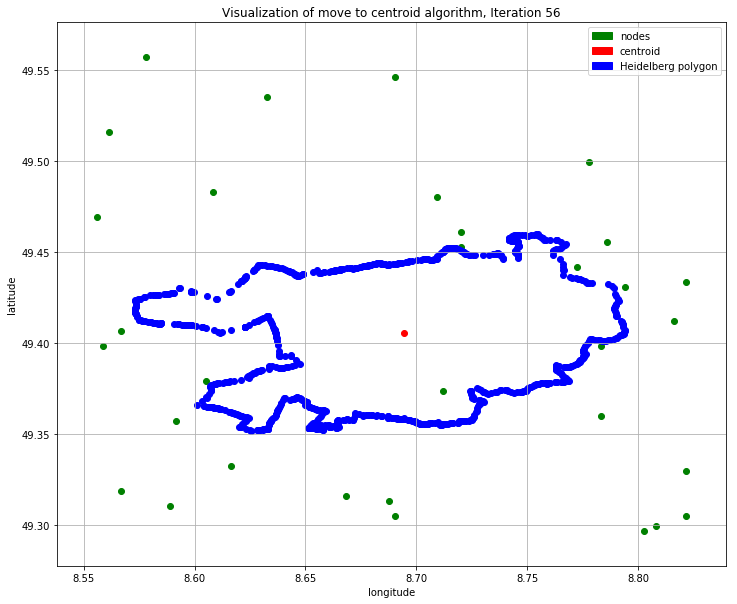

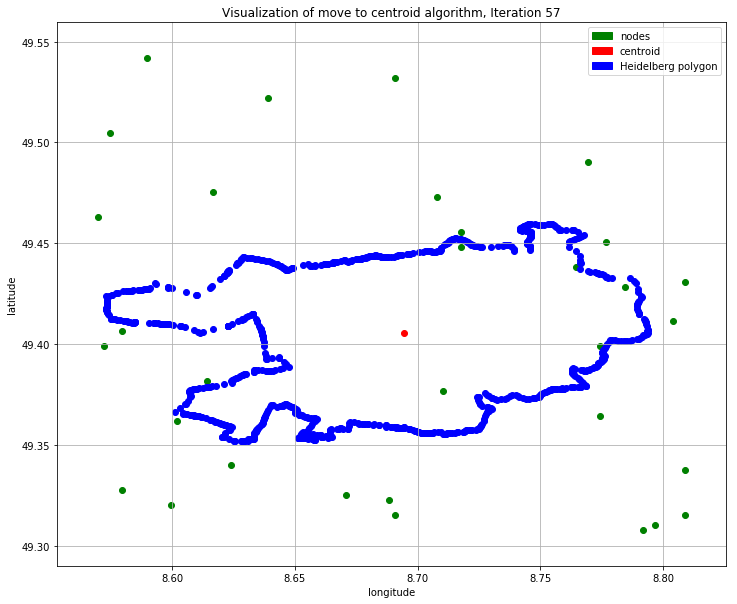

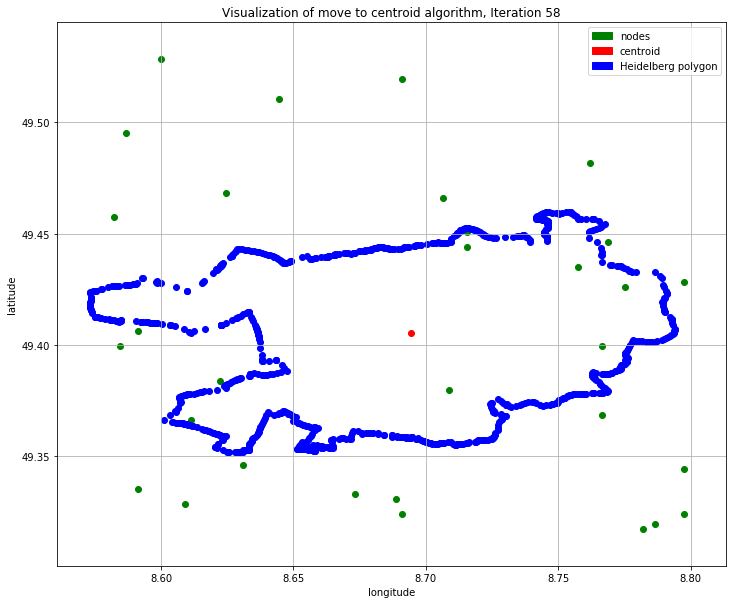

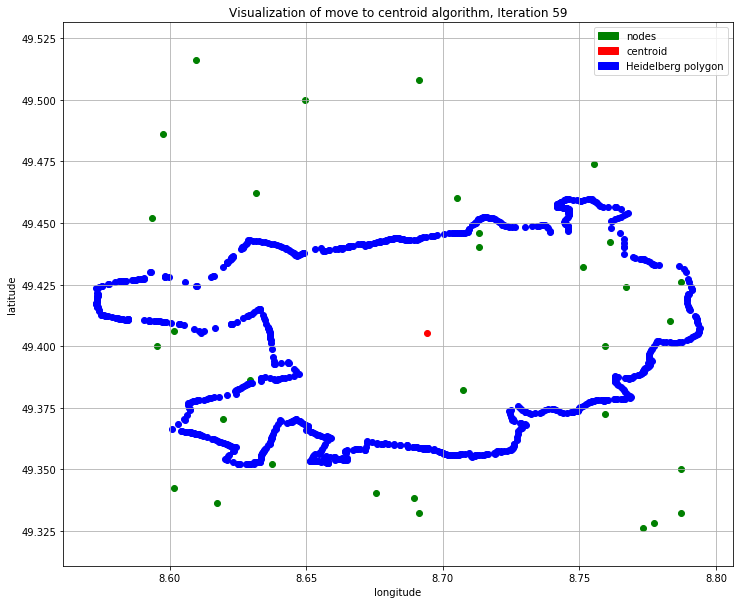

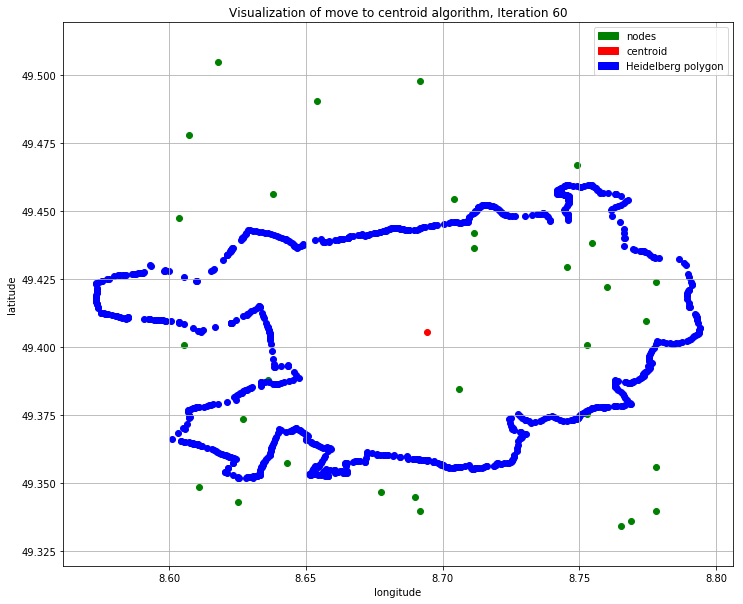

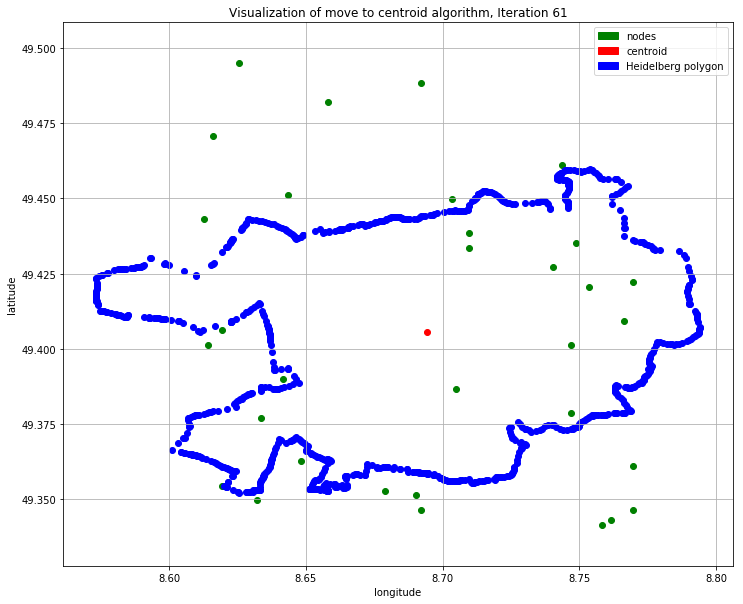

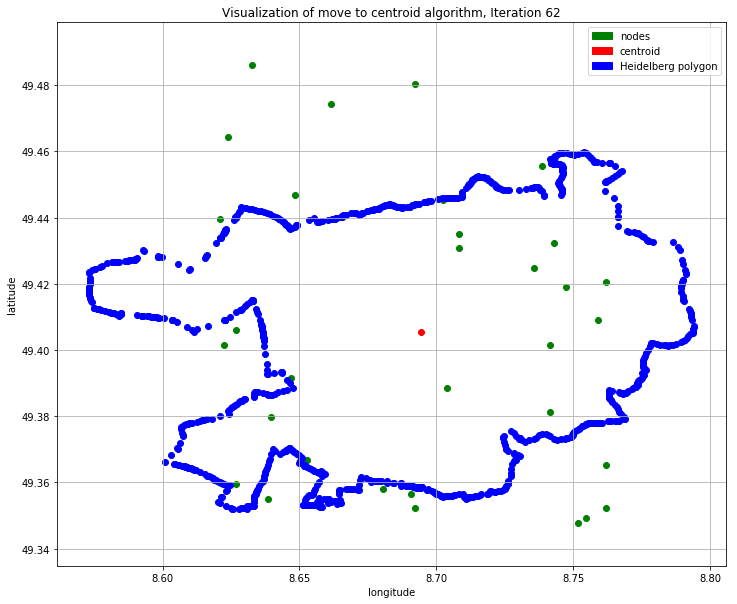

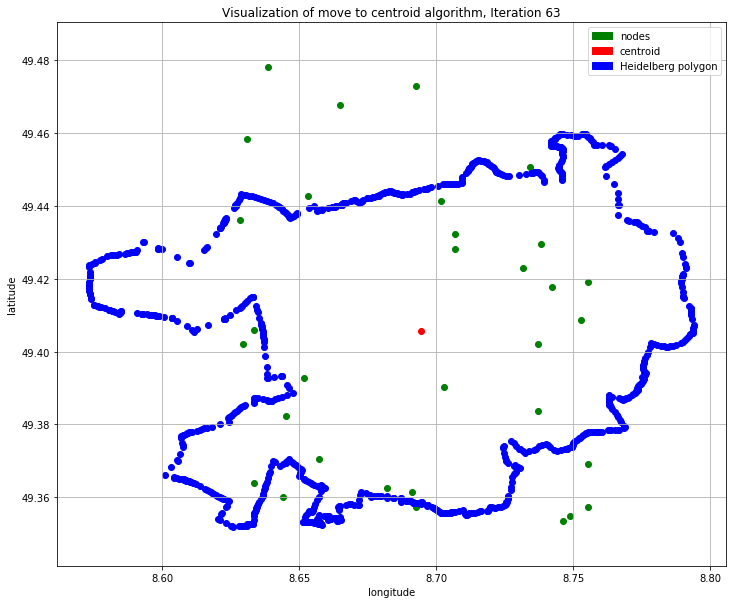

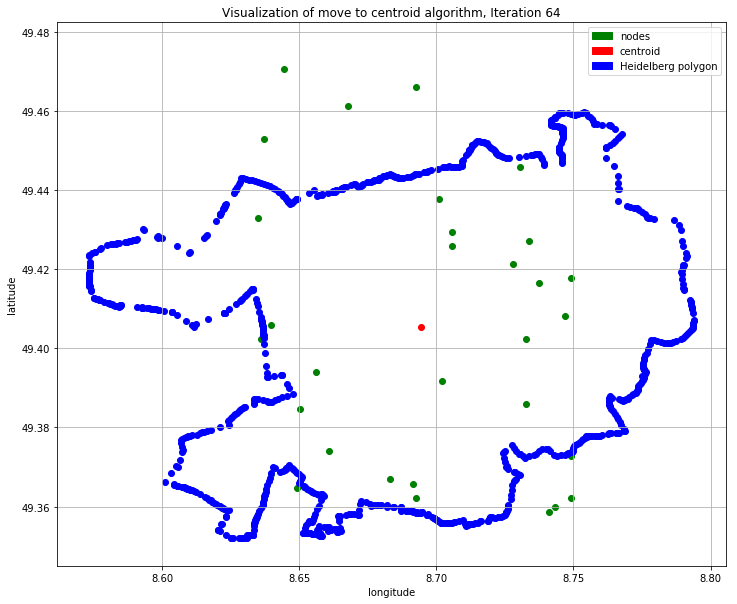

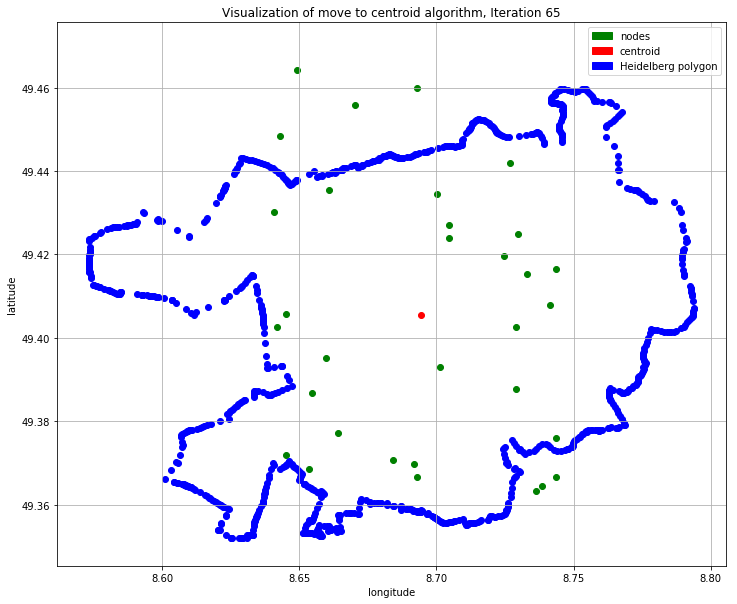

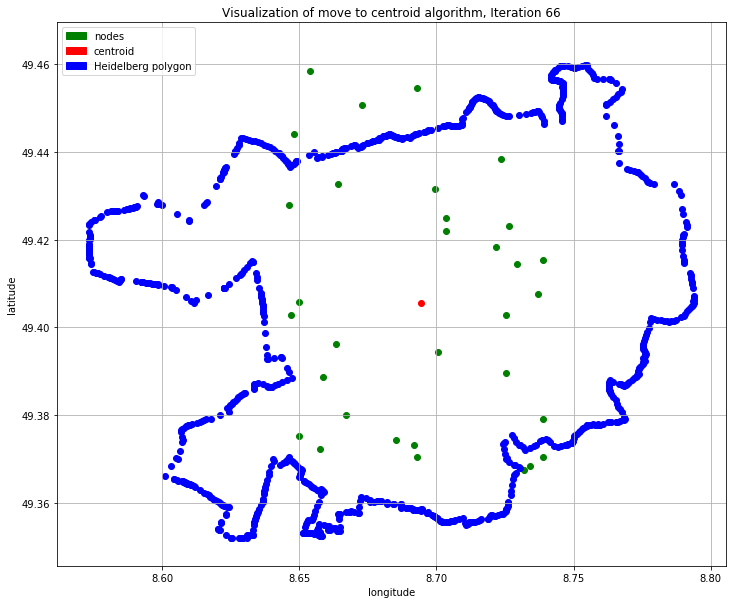

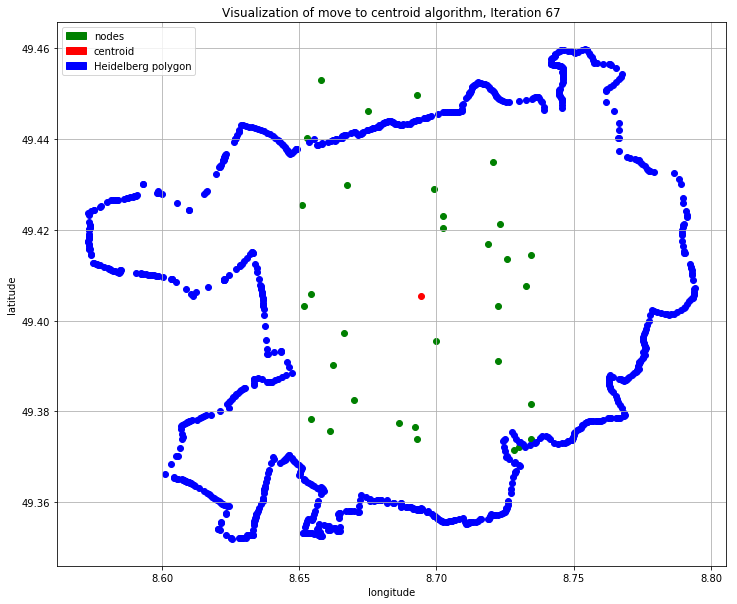

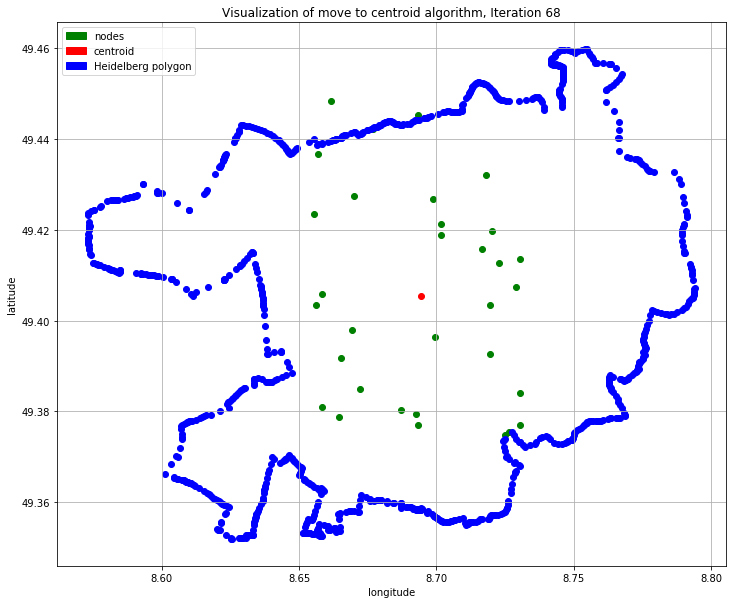

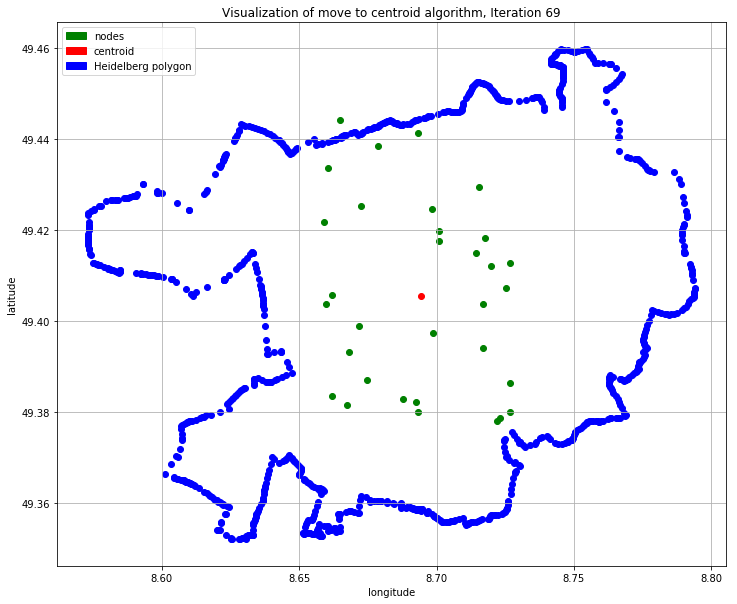

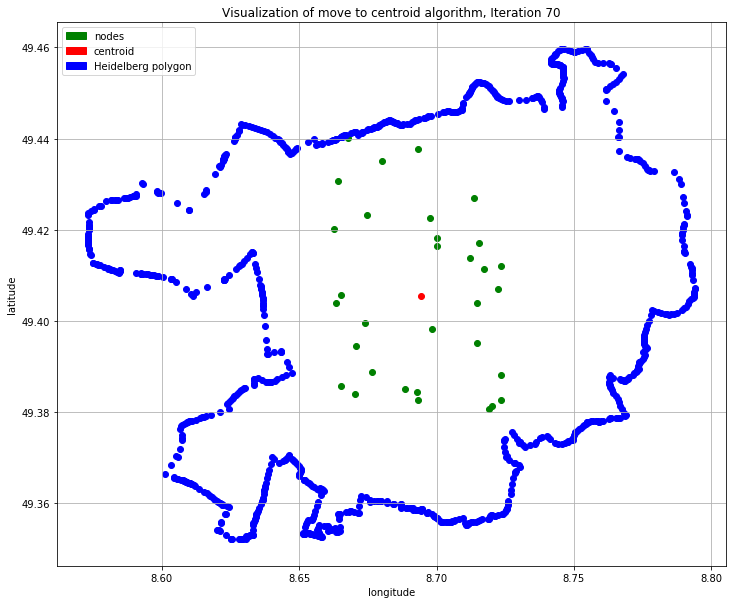

In [5]:
def point_in_polygon(polygon, point):
    polygon_obj = geometry.polygon.Polygon(polygon)
    point_obj = geometry.Point(point)
    return polygon_obj.contains(point_obj)

def move_to_centroid(points, polygon, centroid, move_rate = 0.1):
    counter = 1
    while True:
        any_point_outside = False
        for point in points:
            if point_in_polygon(polygon, point):
                continue
            any_point_outside = True
        if any_point_outside:
            trans_vectors = centroid - points
            points += move_rate * trans_vectors
            fig, ax = plt.subplots(figsize=(12,10))
            ax.scatter(points[:,0], points[:,1], c= 'g')
            ax.scatter(np.mean(points, axis=0)[0], np.mean(points, axis=0)[1], c='r')
            ax.scatter(polygon[:, 0], polygon[:, 1], c='b')
            ax.set_xlabel('longitude')
            ax.set_ylabel('latitude')
            ax.set_title('Visualization of move to centroid algorithm, Iteration {}'.format(counter))
            ax.grid(True)
            green_patch = mpatches.Patch(color='green', label='nodes')
            red_patch = mpatches.Patch(color='red', label='centroid')
            blue_patch = mpatches.Patch(color='blue', label='Heidelberg polygon')
            plt.legend(handles=[green_patch, red_patch, blue_patch])    
            plt.show()
            counter += 1
        else:
            break 
    return np.array(points)

data_mean = np.mean(data, axis=0)
trans_vector = [poly_centroid.x, poly_centroid.y] - data_mean[:-1] 
nodes_centered = data[:,:-1] + trans_vector
nodes_norm = move_to_centroid(nodes_centered, polygon, [poly_centroid.x, poly_centroid.y])

Here, the blue points represents the polygon borders of Heidelberg, the green points the nodes and the red point the centroid of the polygon and the nodes. The end result of the transformation is:

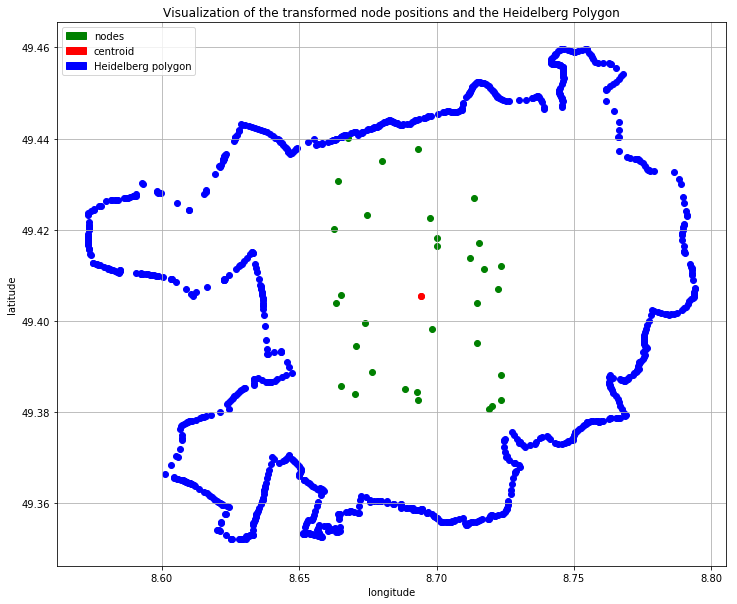

In [6]:
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(nodes_norm[:,0], nodes_norm[:,1], c= 'g')
ax.scatter(np.mean(nodes_norm, axis=0)[0], np.mean(nodes_norm, axis=0)[1], c='r')
ax.scatter(polygon[:, 0], polygon[:, 1], c='b')
ax.scatter(np.mean(nodes_centered, axis=0)[0], np.mean(nodes_centered, axis=0)[1], c='r')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('Visualization of the transformed node positions and the Heidelberg Polygon')
ax.grid(True)
green_patch = mpatches.Patch(color='green', label='nodes')
red_patch = mpatches.Patch(color='red', label='centroid')
blue_patch = mpatches.Patch(color='blue', label='Heidelberg polygon')
plt.legend(handles=[green_patch, red_patch, blue_patch])
plt.show()      

Now, we can plot the nodes and the polygon borders with folium, where the red marker represents the centroid, the blue marker the depot and the green markers the remaining nodes (all nodes that are not depots):

In [7]:
def plot_polygon_with_nodes(polygon, points, centroid, marker_names = None, demands = None):
    plot_map = folium.Map(tiles='stamenterrain',location=(centroid.y, centroid.x), zoom_start=12)
    folium.Marker([centroid.y, centroid.x], popup='<strong>Centroid</strong>', icon=folium.Icon(color='red', icon=None)).add_to(plot_map)
    folium.Marker(points[0, ::-1], popup='<strong>Depot</strong>', icon=folium.Icon(color='blue',icon_color='black', icon='home' , prefix='fa')).add_to(plot_map) # icon warehouse does not work
    if marker_names == None and demands == None:
        for counter, point in enumerate(points[1:]):
            folium.Marker(point[::-1], popup='<strong>Node {}</strong>'.format(counter+1), icon=folium.Icon(color='green', icon_color='black', icon='child', prefix='fa')).add_to(plot_map) # icon box does not work
    elif demands == None:
        for counter, point in enumerate(points[1:]):
            folium.Marker(point[::-1], popup='<strong>Node {}:</strong> {}'.format(counter+1, marker_names[counter]), icon=folium.Icon(color='green', icon_color='black', icon='child', prefix='fa')).add_to(plot_map) # icon box does not work
    elif marker_names == None:
        for counter, point in enumerate(points[1:]):
            folium.Marker(point[::-1], popup='<strong>Node {}</strong><br>demand: {}'.format(counter+1, demands[counter]), icon=folium.Icon(color='green', icon_color='black', icon='child', prefix='fa')).add_to(plot_map) # icon box does not work
    else:
        for counter, point in enumerate(points[1:]):
            folium.Marker(point[::-1], popup='<strong>Node {}:</strong> {} <br>demand: {}'.format(counter+1, marker_names[counter], demands[counter]), icon=folium.Icon(color='green', icon_color='black', icon='child', prefix='fa')).add_to(plot_map) # icon box does not work
    folium.features.PolygonMarker(polygon, popup='Heidelberg Polygon', color='#000000', fill_color='#140e8c', fill_opacity=0.2, weight=3).add_to(plot_map)
    display(plot_map)
    
plot_polygon_with_nodes(poly_coords, nodes_norm, poly_centroid)

As we can see some of the nodes are not in the city of Heidelberg, but somewhere in the mountain. We can shift them a bit by linear translation to get more nodes that are actually reachable by our delivery vehicles. Recall that any linear translation or rotation does not inherently change the problem. Mathematically, it remains the same problem.

In [8]:
nodes_norm_shift = nodes_norm + np.array([-3e-2, -1e-2])
plot_polygon_with_nodes(poly_coords, nodes_norm_shift, poly_centroid)

Some of the nodes are still not reachable by vehicles, especially the nodes on the bottom left corner. To solve this issue, we will use the openrouteservice API for reverse geocoding the nodes. Thereby, the geographical coordinates of the nodes will be converted into addresses of the next enclosing object with an address tag. First, we need an API-key, which can be obtained at [**Openrouteservice**](https://openrouteservice.org/sign-up/) for free by signing up as a developer. Using the API reserve geocoding feature, we get real-world addresses for the nodes. For all functions provided by the openrouteservice API refer to the [**documentation**](https://openrouteservice.org/documentation/#/reference/directions/directions/geocoding-service).

In [9]:
api_key = '58d904a497c67e00015b45fc9298e8d961e64b48b066a43e51d39887'
client = openrouteservice.Client(key=api_key)

name_lst = []
for node in nodes_norm_shift.tolist():
    response = client.reverse_geocode(location=node)
    name = response['features'][0]['properties']['name'] 
    name_lst.append(name)
    
df_address = pd.DataFrame(name_lst, columns=['address obtained by reverse geocoding'])
df_address.columns.name = 'node number'
df_address['demand'] = df_data['demand']
display(df_address)

node number,address obtained by reverse geocoding,demand
0,Quinckestraße 49,0
1,Bergfriedhof,19
2,Hedwig-Jochmus-Straße 16,21
3,Gertrude-von-Ubisch-Straße,6
4,Speyerer Straße,19
5,Klostergasse 6,7
6,Spielpavillon mit Drehwelt,12
7,Feuerbachstraße 26,16
8,Grasweg,6
9,"Justus-von-Liebig-Straße 10, 10a, 10b, 10c",16


Using the geocode feature of the openrouteservice API, we obtain the x- and y-coordinates of the nodes back. Using reverse geocoding and than geocoded the addresses back to coordinates ensures that all node coordinates represent real-world streets making the generated problem solvable in the first place. 

In [10]:
geocoded_nodes = []
for name in name_lst:
    response = client.geocode(query={"address": name, "locality": "Heidelberg", "country": "Germany", "postalcode": "69120"})
    geocode = response['features'][0]['geometry']['coordinates']
    geocoded_nodes.append(geocode)
nodes = np.array(geocoded_nodes)
df_nodes = pd.DataFrame(nodes, columns=['longitude', 'latitude'])
df_nodes.columns.name = 'node number'
df_nodes['demand'] = df_data['demand']
df_nodes['address'] = pd.Series(name_lst).values
display(df_nodes)

Request limit of 40 per minute exceeded. Wait for 58.61992120742798 seconds


node number,longitude,latitude,demand,address
0,8.683448,49.416961,0,Quinckestraße 49
1,8.681247,49.412388,19,Bergfriedhof
2,8.681247,49.412388,21,Hedwig-Jochmus-Straße 16
3,8.662789,49.374460,6,Gertrude-von-Ubisch-Straße
4,8.663488,49.390504,19,Speyerer Straße
5,8.650365,49.424738,7,Klostergasse 6
6,8.681247,49.412388,12,Spielpavillon mit Drehwelt
7,8.684574,49.393819,16,Feuerbachstraße 26
8,8.681247,49.412388,6,Grasweg
9,8.681247,49.412388,16,"Justus-von-Liebig-Straße 10, 10a, 10b, 10c"


The downside is that originally different nodes might have the same coordinates after the geocoding process. Node 1, 2, 6, 8, 9, 16, 20, 23, 27 and 28 have the same coordinate as well as node 10 and 11. We will delete those node duplicates and calculate how many demands were deleted in the process. 

In [11]:
to_delete_indices = [2, 6, 8, 9, 16, 20, 23, 27, 28, 11]
sum_deleted_demand = 0
for i in to_delete_indices:
    sum_deleted_demand += data[:, -1][i]
unique_nodes = np.delete(nodes, to_delete_indices, axis=0)
demands = np.delete(data[:, -1], to_delete_indices)
names = np.delete(name_lst, to_delete_indices)
print("{} demands were deleted in this process.".format(sum_deleted_demand))
print("There are {} remaining nodes (excluding the depot) after the deleting process.".format(len(unique_nodes) - 1))

138 demands were deleted in this process.
There are 21 remaining nodes (excluding the depot) after the deleting process.


To accommodate for the 138 deleted demands, we reduce the number of vehicle from 5 to 4 (reminder: a vehicle has a capacity of 100). The remaining 38 demands will be randomly distributed among the 21 nodes. The end result is the generated capacitated vehicle routing problem (CVRP) that we will attempt to solve.

In [12]:
for node_num in np.random.randint(1, 22, size=38):
    demands[node_num] += 1
df_CVRP = pd.DataFrame(unique_nodes, columns=['longitude', 'latitude'])
df_CVRP.columns.name = 'node number'
df_CVRP['demand'] = pd.Series(demands).values
df_CVRP['address'] = pd.Series(names).values
display(df_CVRP)

node number,longitude,latitude,demand,address
0,8.683448,49.416961,0,Quinckestraße 49
1,8.681247,49.412388,24,Bergfriedhof
2,8.662789,49.374460,6,Gertrude-von-Ubisch-Straße
3,8.663488,49.390504,20,Speyerer Straße
4,8.650365,49.424738,9,Klostergasse 6
5,8.684574,49.393819,19,Feuerbachstraße 26
6,8.636446,49.430018,11,A 5
7,8.693395,49.401669,22,Mittlerer Gaisbergweg 11
8,8.685109,49.387783,18,Eisenhower Street
9,8.670162,49.406377,6,Czernyring 10


For visualization we plot the end version of the generated capacitated vehicle routing problem:

In [13]:
plot_polygon_with_nodes(poly_coords, unique_nodes, poly_centroid, list(names), list(demands))

Finally, we save the generated capacitated vehicle routing problem in a csv file for further usage.

In [14]:
df_CVRP.to_csv("capacitated vehicle routing problem")
print(poly_coords)

[(49.4157627, 8.5734302), (49.416518, 8.573288), (49.4169018, 8.5732227), (49.4172172, 8.5732061), (49.4175624, 8.5732105), (49.4180262, 8.5732329), (49.4182387, 8.5732441), (49.4184603, 8.5732621), (49.418634, 8.5732802), (49.4191025, 8.5732535), (49.4198517, 8.5734867), (49.4202081, 8.5735754), (49.4204778, 8.5736183), (49.4207656, 8.5736296), (49.4210285, 8.5736023), (49.4217462, 8.5735169), (49.4232662, 8.5732443), (49.4235999, 8.5731788), (49.4240214, 8.5742425), (49.4244224, 8.5752902), (49.4243563, 8.5753853), (49.4250846, 8.5772883), (49.4252735, 8.5777912), (49.4261985, 8.5798331), (49.4264503, 8.5813791), (49.4264726, 8.582023), (49.4265061, 8.5829195), (49.4265415, 8.5835079), (49.4265995, 8.5840786), (49.4268456, 8.5862321), (49.4269339, 8.5870795), (49.4269574, 8.5872399), (49.4270379, 8.5877643), (49.427151, 8.5884423), (49.4272957, 8.589435), (49.4273293, 8.5897569), (49.4273469, 8.5900544), (49.4273672, 8.5904498), (49.4277347, 8.5907782), (49.4301327, 8.5929629), (49.4

In [17]:
print(list(names))


['Quinckestraße 49', 'Bergfriedhof', 'Gertrude-von-Ubisch-Straße', 'Speyerer Straße', 'Klostergasse 6', 'Feuerbachstraße 26', 'A 5', 'Mittlerer Gaisbergweg 11', 'Eisenhower Street', 'Czernyring 10', 'Handelsstraße 1', 'Traitteurweg', 'Baumschulenweg', 'Schleifweg 44', 'Oelgasse 1a', 'Rudolf-Diesel-Straße 20', 'Yorckstraße', 'Am Taubenfeld 35', 'Ringstraße 19a', 'Wieblinger Weg 100a', 'Alte Glockengießerei', 'Hermann-Schück-Weg 1']
